In [1]:
%pylab
%matplotlib inline
%reload_ext autoreload


import pandas as pd
import sys
#import seaborn as sns
sys.path.append('../../src')
if sys.platform != 'darwin':
    os.environ["R_HOME"] = r"C:\\Program Files\\R\\R-3.6.0" # change as needed
%load_ext rpy2.ipython

import abrTools as at
import os
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report
from collections import Counter
import pretty_confusion_matrix as pcm
from scipy.signal import savgol_filter


fs = 195000.0/2.0 # Acquisition sampling rate

from datetime import date
savefolder = os.path.join('..','results',str(date.today()))


from matplotlib.pyplot import errorbar
rcParams["font.family"] = "Arial"
rcParams['axes.linewidth'] = 5
rcParams["xtick.major.size"] = 20
rcParams["xtick.major.width"] = 5
rcParams["xtick.major.pad"] = 10

rcParams["ytick.major.size"] = 20
rcParams["ytick.major.width"] = 5
rcParams["xtick.minor.size"] = 10
rcParams["xtick.minor.width"] = 5

rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
markersize=40#35
fontSize = 54*1.8# 54
import matplotlib.gridspec as gridspec

resultFolder =  '../../results/2024-10-25-main-optimisedForF1Score'#'../../../results/2024-03-15-main'
import figureTools

Using matplotlib backend: module://matplotlib_inline.backend_inline
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
X_train,  X_test,y_train,y_test,dataVersion = at.createClassificationDataset(datafolder='../../data',test_size=0.25,oversample=False,ages=[1,])
X = np.vstack([X_train,X_test])
y = np.hstack([y_train,y_test])

The dataset version is: 20230914 - V41
Counter({np.str_('Repaired'): 54, np.str_('6N'): 50})


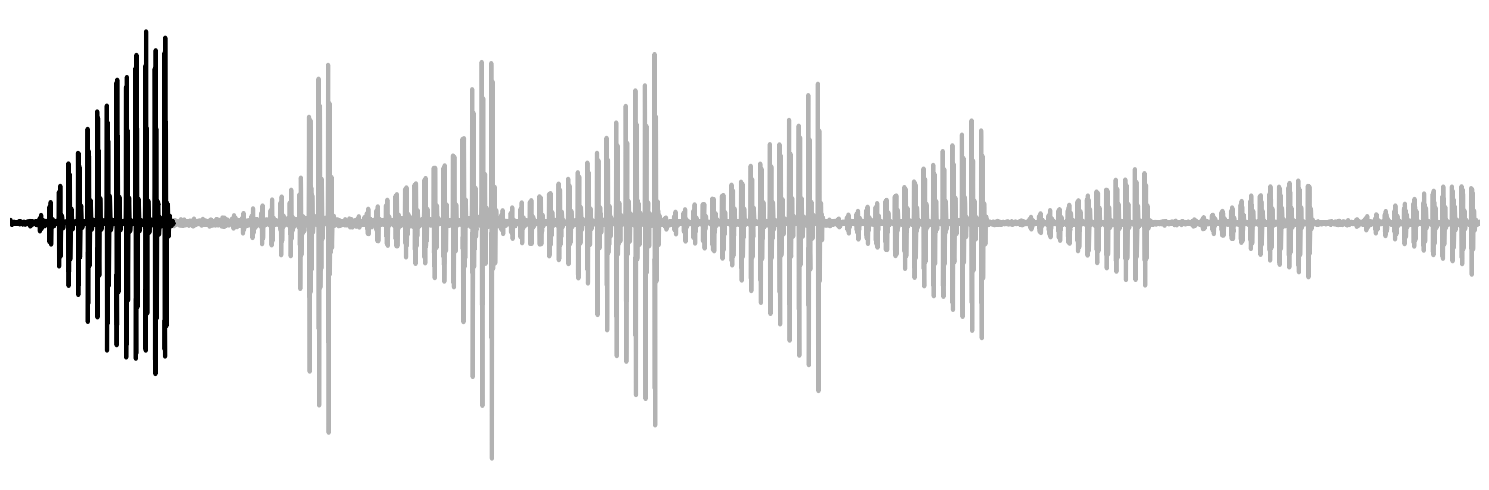

In [3]:
fig = figure(figsize(15,5))
ax = subplot(111)
ax.plot(X.mean(0)[:1953*17:20],'k',linewidth=3)
xlim(0,1953*17*9/20)
ax.plot(np.arange(1953*17/20,1953*17*9/20),X.mean(0)[1953*17::20],'k',alpha=0.3,linewidth=3)

ax.set_axis_off()
tight_layout()
savefig('./Panels/sampletrace_click.pdf',dpi=1200,transparent=True)

Collect results

In [4]:
master = at.collectResults(resultFolder)

master['accuracy'] = master['accuracy']*100
master['test_precision_scorer_avg'] = master['test_precision_scorer_avg']*100
master['test_recall_scorer_avg'] = master['test_recall_scorer_avg']*100
master['roc_auc_score'] = master['roc_auc_score']*100
master['test_precision_scorer_6N'] = master['test_precision_scorer_6N']*100
master['test_recall_scorer_6N'] = master['test_recall_scorer_6N']*100
master['test_f1_scorer_6N'] = master['test_f1_scorer_6N']*100

master['test_precision_scorer_Rep'] = master['test_precision_scorer_Rep']*100
master['test_recall_scorer_Rep'] = master['test_recall_scorer_Rep']*100
master['test_f1_scorer_Rep'] = master['test_f1_scorer_Rep']*100



array(['HiveCote Anova FS', 'MLP Anova FS', 'Random Forest Anova FS',
       'Rocket Anova FS', 'SVC Anova FS', 'XGBOOST Anova FS'],
      dtype=object)
master.loc[master['Model']=='HiveCote Anova FS','Model'] = 'HC'
master.loc[master['Model']=='MLP Anova FS','Model'] = 'MLP'
master.loc[master['Model']=='SVC Anova FS','Model'] = 'SVM'
master.loc[master['Model']=='Random Forest Anova FS','Model'] = 'RF'
master.loc[master['Model']=='Rocket Anova FS','Model'] = 'Rckt'
master.loc[master['Model']=='XGBOOST Anova FS','Model'] = 'XGB'

Check that we have 6 models

In [2]:
master['Model'].unique()

NameError: name 'master' is not defined

In [3]:
df = master.query("Frequency=='Click'")
df.drop(['p_value','Frequency'],axis=1,inplace=True)
df.groupby('Model').agg([mean,std]).to_csv('Click_cv_averagescores.csv')

NameError: name 'master' is not defined

In [4]:
df.groupby('Model').agg([mean,std])

NameError: name 'df' is not defined

Statistics on scores to test whether significant differences exist in the performances of the models.

Friedman test statistic: 13.85507246376816, p-value: 0.01655670108294073
Significant differences found, performing Nemenyi post-hoc test...
Nemenyi post-hoc p-values:
            HC       MLP        RF      Rckt       SVM       XGB
HC    1.000000  0.979815  0.318980  0.968676  0.071061  0.278521
MLP   0.979815  1.000000  0.772426  1.000000  0.340333  0.728046
RF    0.318980  0.772426  1.000000  0.813413  0.984153  1.000000
Rckt  0.968676  1.000000  0.813413  1.000000  0.385076  0.772426
SVM   0.071061  0.340333  0.984153  0.385076  1.000000  0.990733
XGB   0.278521  0.728046  1.000000  0.772426  0.990733  1.000000


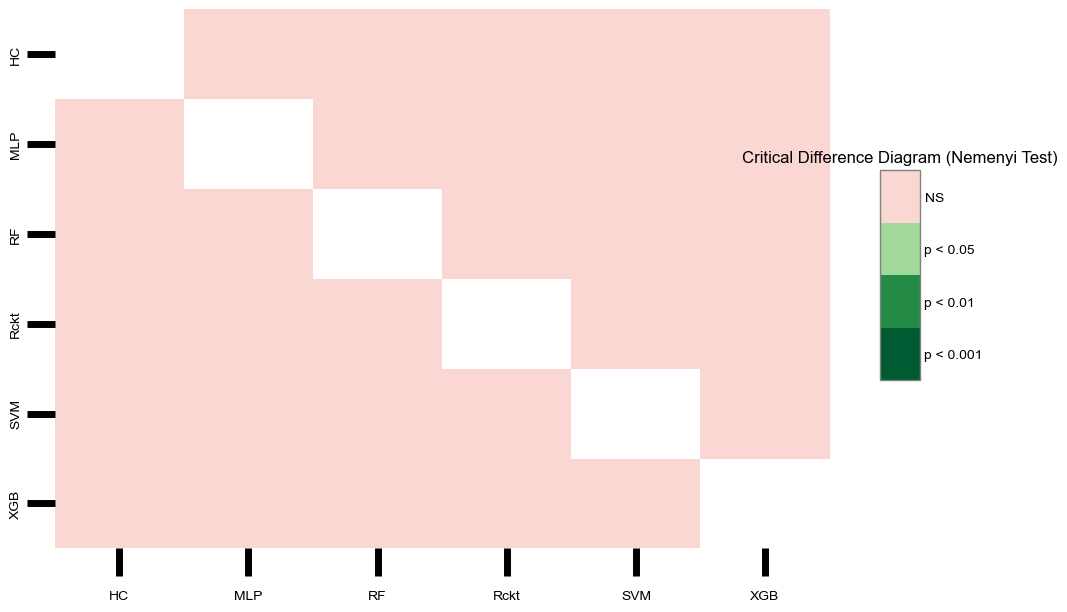

In [11]:
# Statistics using friedman test followed by Nemenyi posthoc 

from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
metric = 'test_precision_scorer_6N'

# Example data: model performances across cross-validation folds
# Rows: cross-validation folds
# Columns: models

# For example, model accuracies across 10 cross-validation folds for 6 models
data1 = df[[metric,'Model']].pivot(columns='Model',values=metric)
data = data1.values


# Perform Friedman test
stat, p_value = friedmanchisquare(*data.T)  # Use .T to transpose for the correct shape
print(f'Friedman test statistic: {stat}, p-value: {p_value}')

if p_value < 0.05:
    print("Significant differences found, performing Nemenyi post-hoc test...")

    # Perform Nemenyi post-hoc test
    nemenyi_result = sp.posthoc_nemenyi_friedman(data1)

    # Display the pairwise p-values from the Nemenyi test
    print("Nemenyi post-hoc p-values:")
    print(nemenyi_result)

    # Optional: Plot a heatmap of the pairwise p-values
    labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']
    plt.figure(figsize=(10, 7))
    sp.sign_plot(nemenyi_result, labels=True)
    plt.title("Critical Difference Diagram (Nemenyi Test)")
    plt.show()
else:
    print("No significant differences found among models.")

In [5]:
df = master.query("Frequency=='Click'")
df.drop(['p_value','Frequency'],axis=1,inplace=True)
df.groupby('Model').agg([mean,std]).to_csv('Global_cv_averagescores.csv')
df.groupby('Model').mean()

/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_21666/3335828317.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['p_value','Frequency'],axis=1,inplace=True)
/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_21666/3335828317.py:3: FutureWarning: The provided callable <function mean at 0x11451f380> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby('Model').agg([mean,std]).to_csv('Global_cv_averagescores.csv')
/var/folders/n2/bkzw0ff907zgpgprdz_rg_tr0000gn/T/ipykernel_21666/3335828317.py:3: FutureWarning: The provided callable <function std at 0x11451f4c0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided cal

accuracy  test_f1_scorer_avg  test_f1_scorer_6N  test_f1_scorer_Rep  \
Model                                                                         
HC     84.964286            0.848476          83.818193           85.716414   
MLP    83.071429            0.828070          81.803669           83.663405   
RF     78.964286            0.786820          77.638802           79.556038   
Rckt   83.670635            0.834761          82.546823           84.228744   
SVM    80.261905            0.794772          79.823429           79.146955   
XGB    79.134921            0.786334          78.412701           78.780095   

       roc_auc_score  test_precision_scorer_avg  test_precision_scorer_6N  \
Model                                                                       
HC         90.772817                  86.227482                 85.702597   
MLP        90.249008                  84.733266                 84.164358   
RF         90.921131                  80.807797                 80.099423   
Rckt       83.670635                  85.351681                 84.796825   
SVM        90.965278                  82.219069                 78.473016   
XGB        88.490079                  81.011934                 78.500577   

       test_precision_scorer_Rep  test_recall_scorer_avg  \
Model                                                      
HC                     86.563492               85.033333   
MLP                    85.184993               83.166667   
RF                     81.345887               79.033333   
Rckt                   85.761472               83.783333   
SVM                    85.493218               80.083333   
XGB                    83.145599               79.050000   

       test_recall_scorer_6N  test_recall_scorer_Rep  
Model                                                 
HC                 83.428571               86.500000  
MLP                81.642857               84.500000  
RF                 77.928571               80.000000  
Rckt               82.285714               85.055556  
SVM                83.357143               77.166667  
XGB                80.714286               77.555556

#Make all panels

/Users/federico/Desktop/ABR-ML 2/ABR-ML-analysis/notebooks/Paper/figureTools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Model idx'] = le.transform(df['Model'])
/Users/federico/Desktop/ABR-ML 2/ABR-ML-analysis/notebooks/Paper/figureTools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Model idx'] = le.transform(df['Model'])
/Users/federico/Desktop/ABR-ML 2/ABR-ML-analysis/notebooks/Paper/figureTools.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

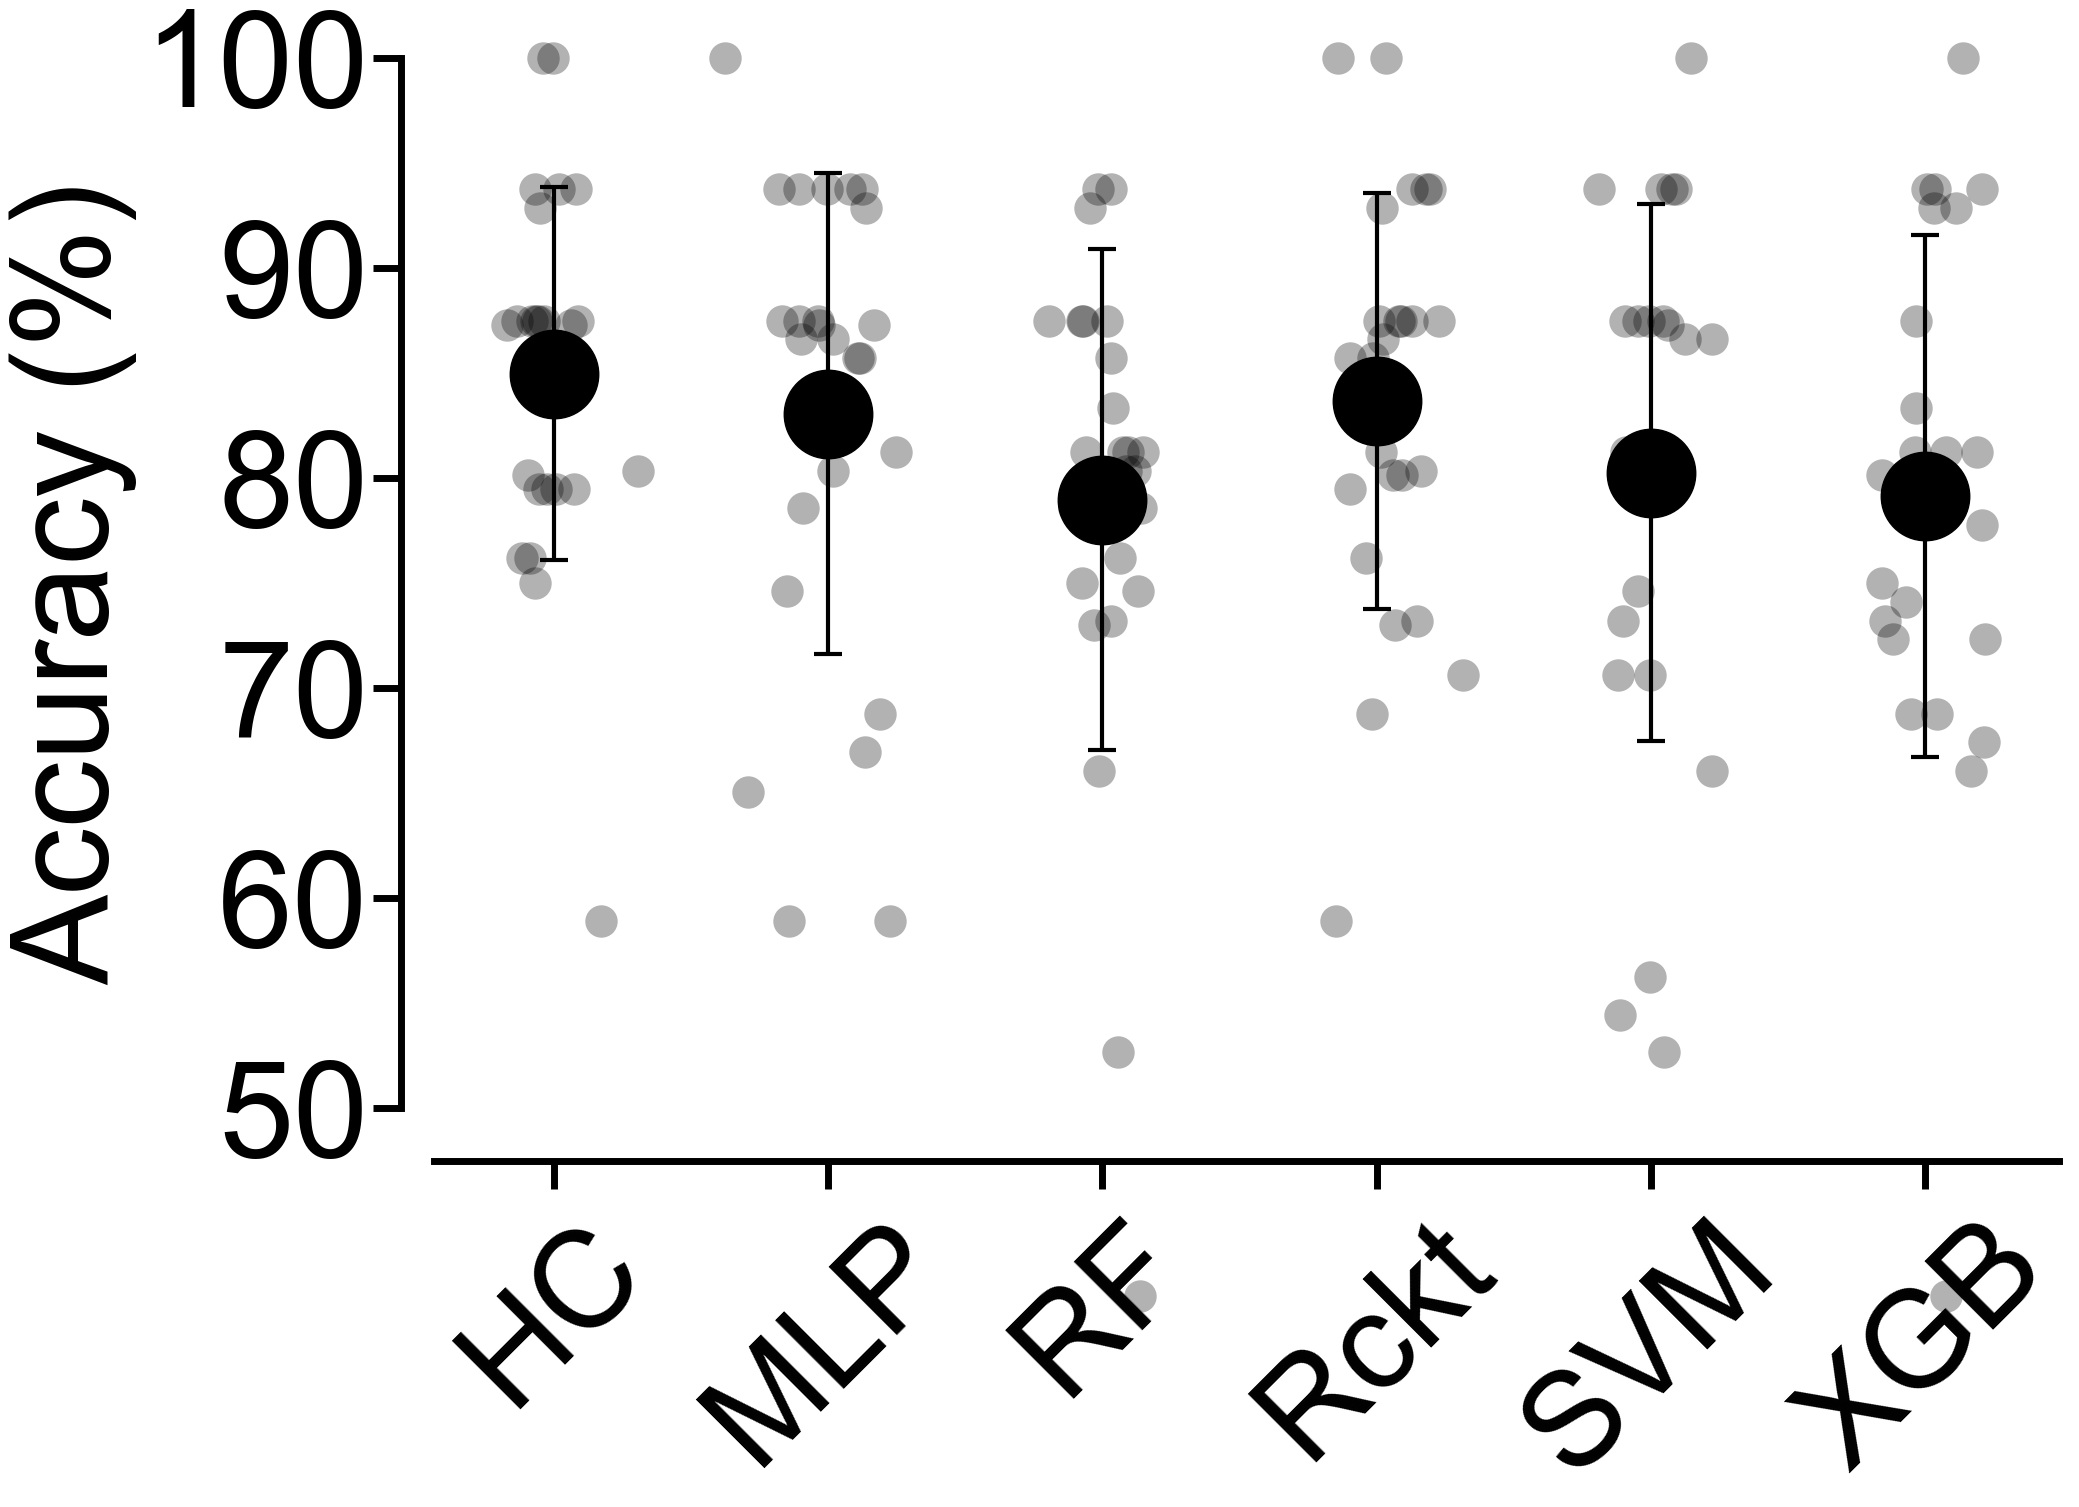

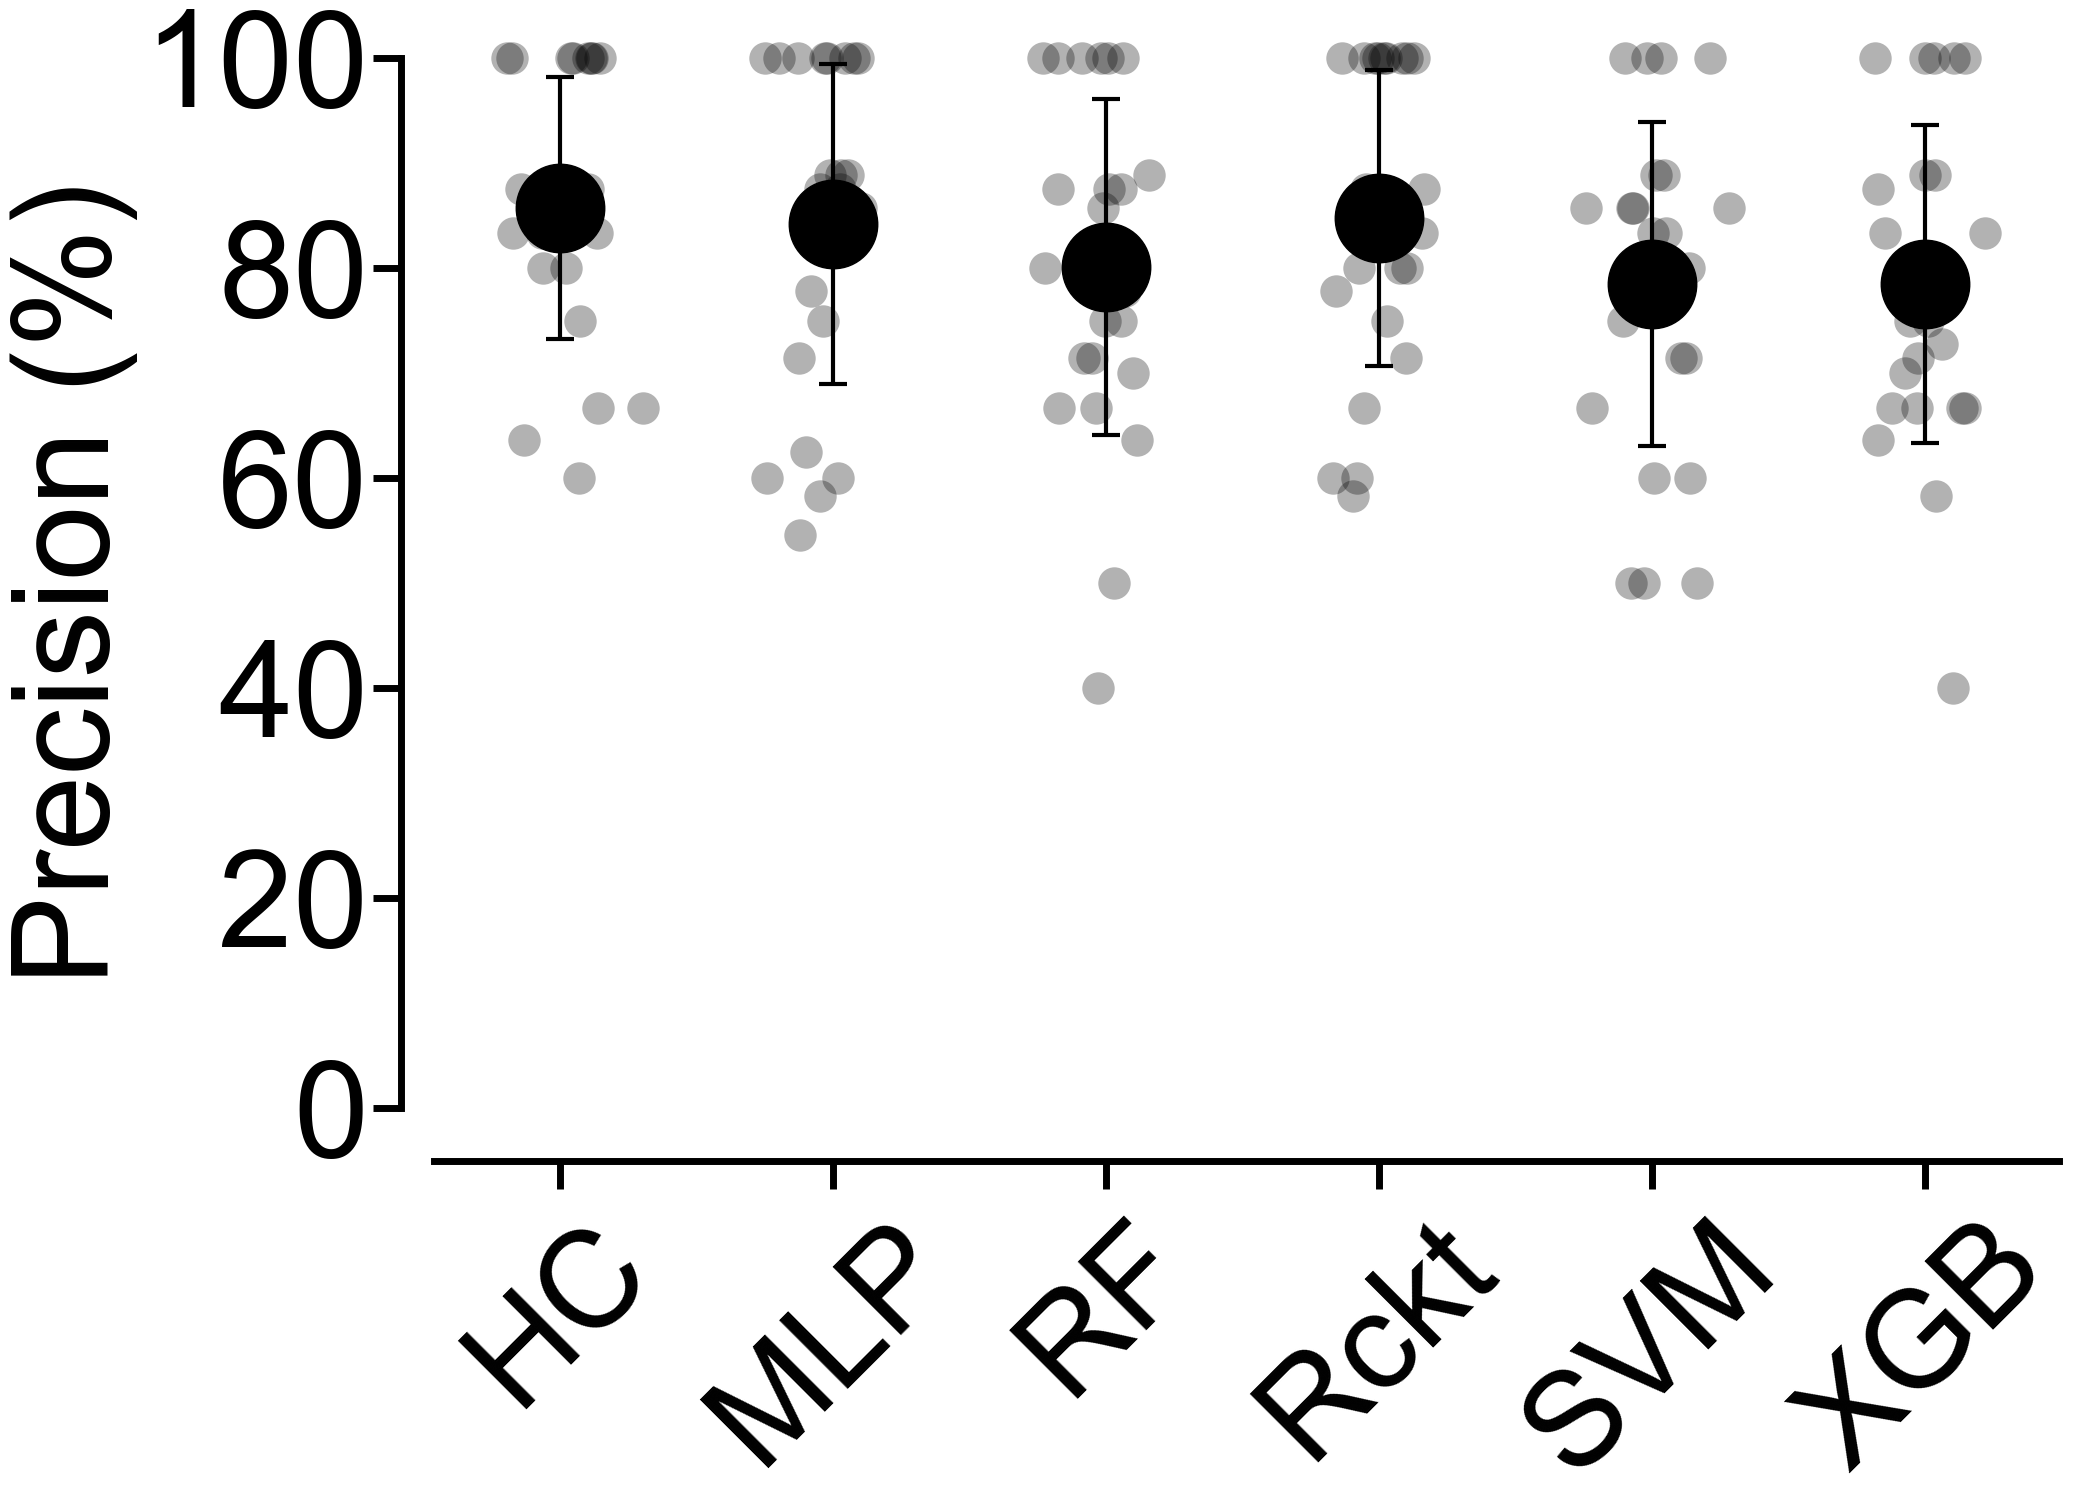

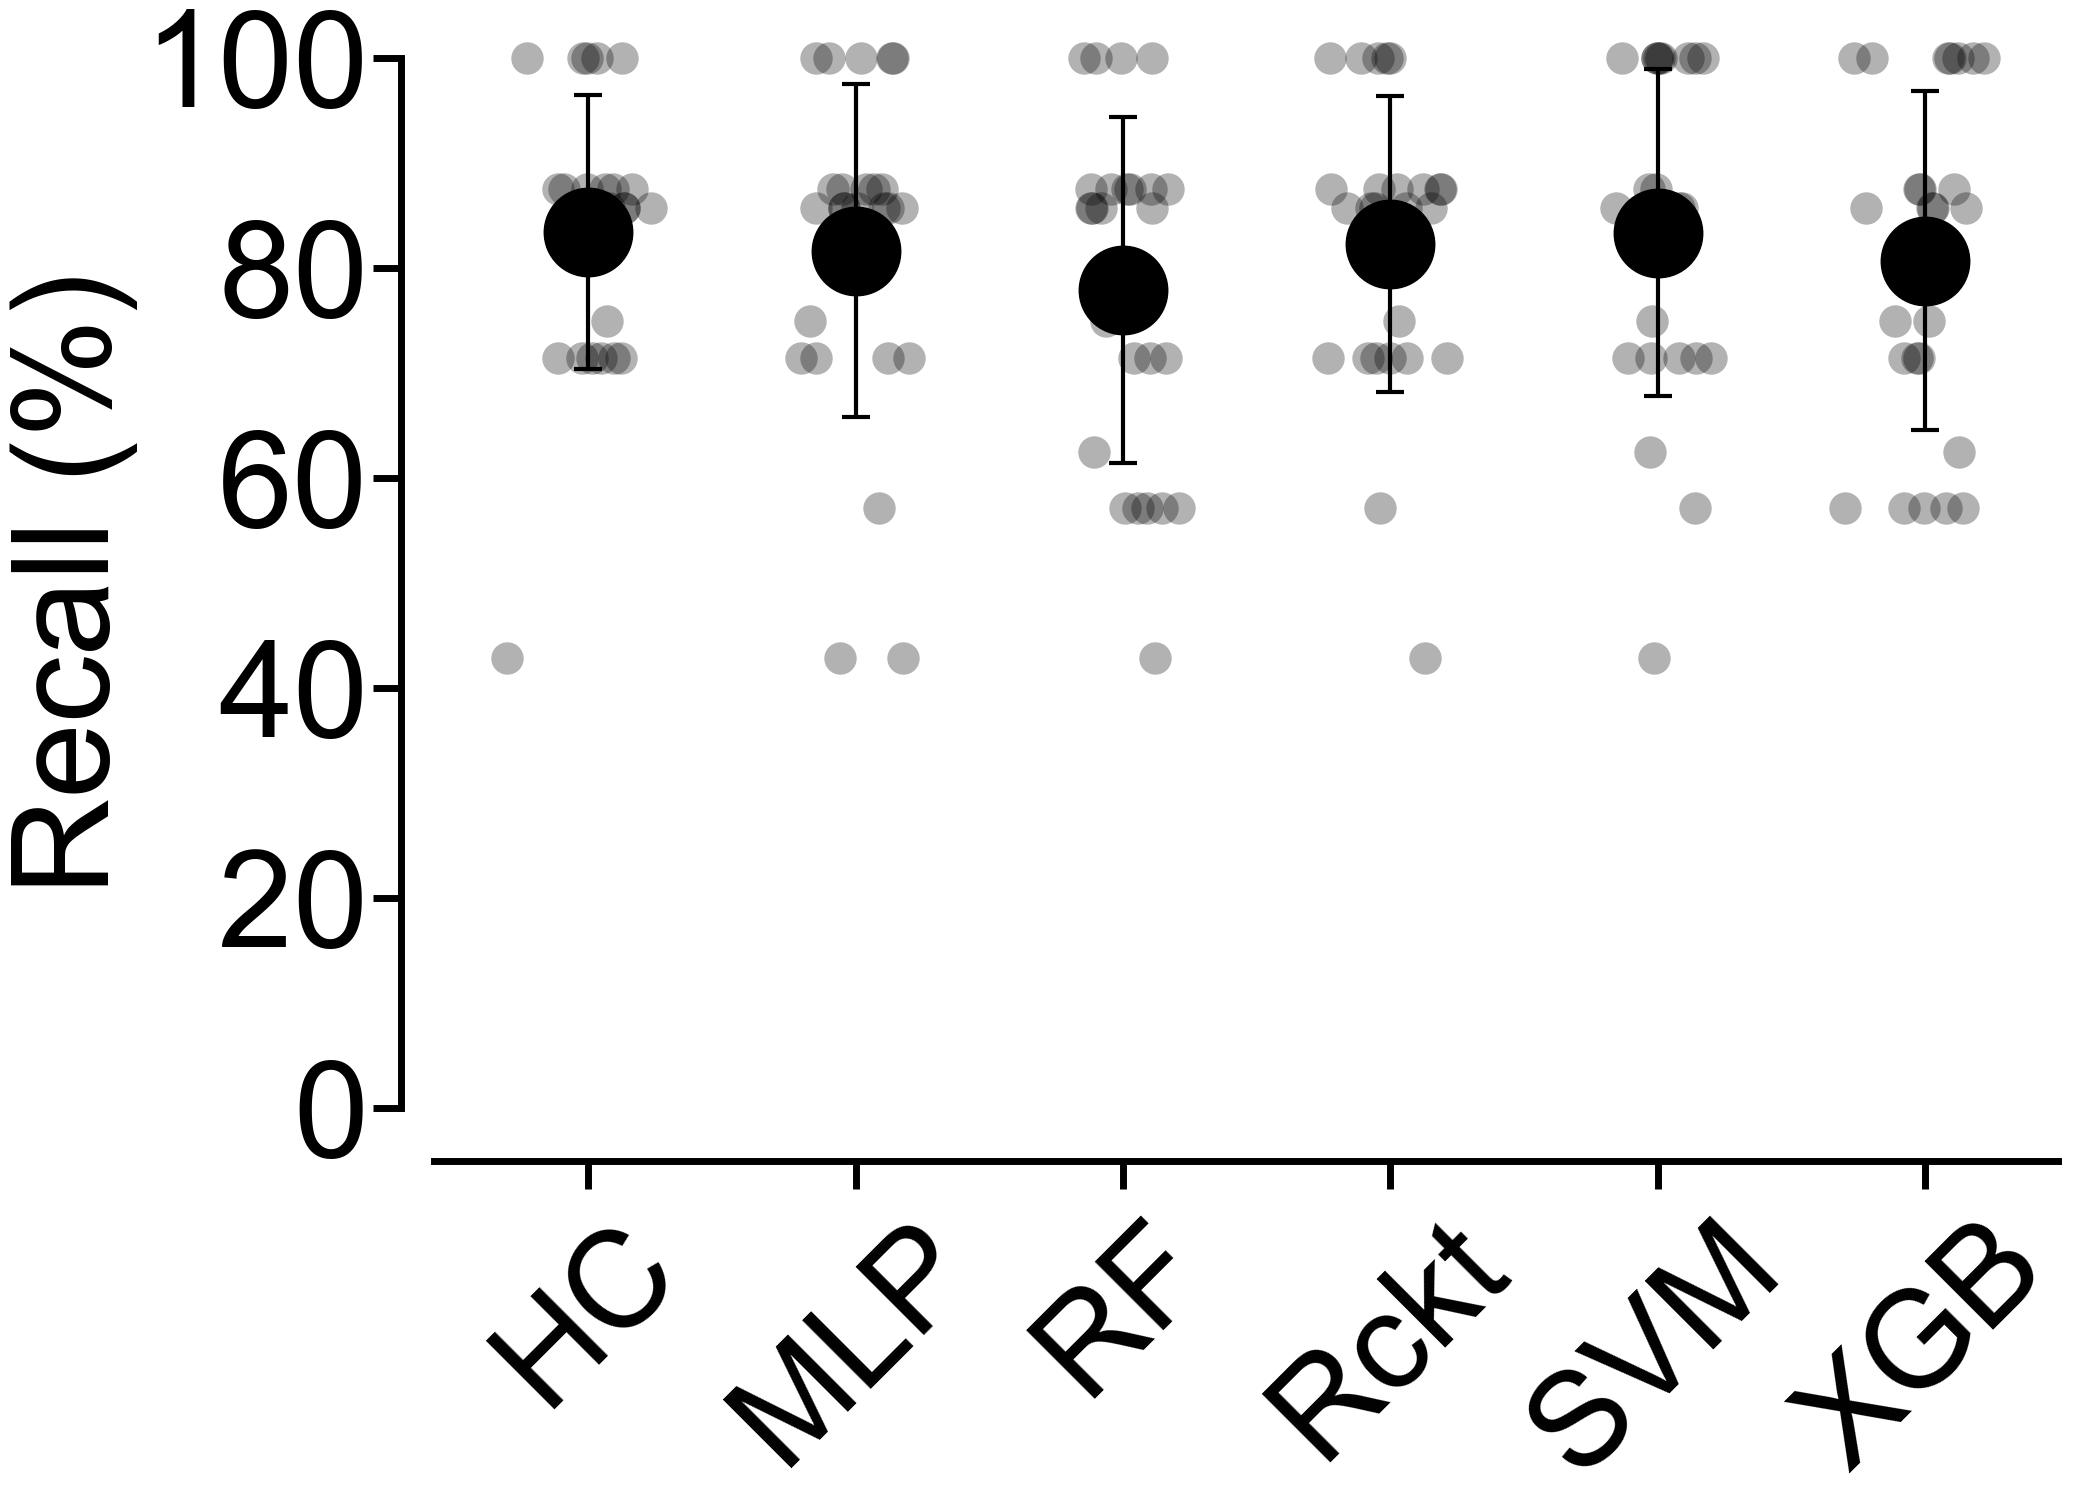

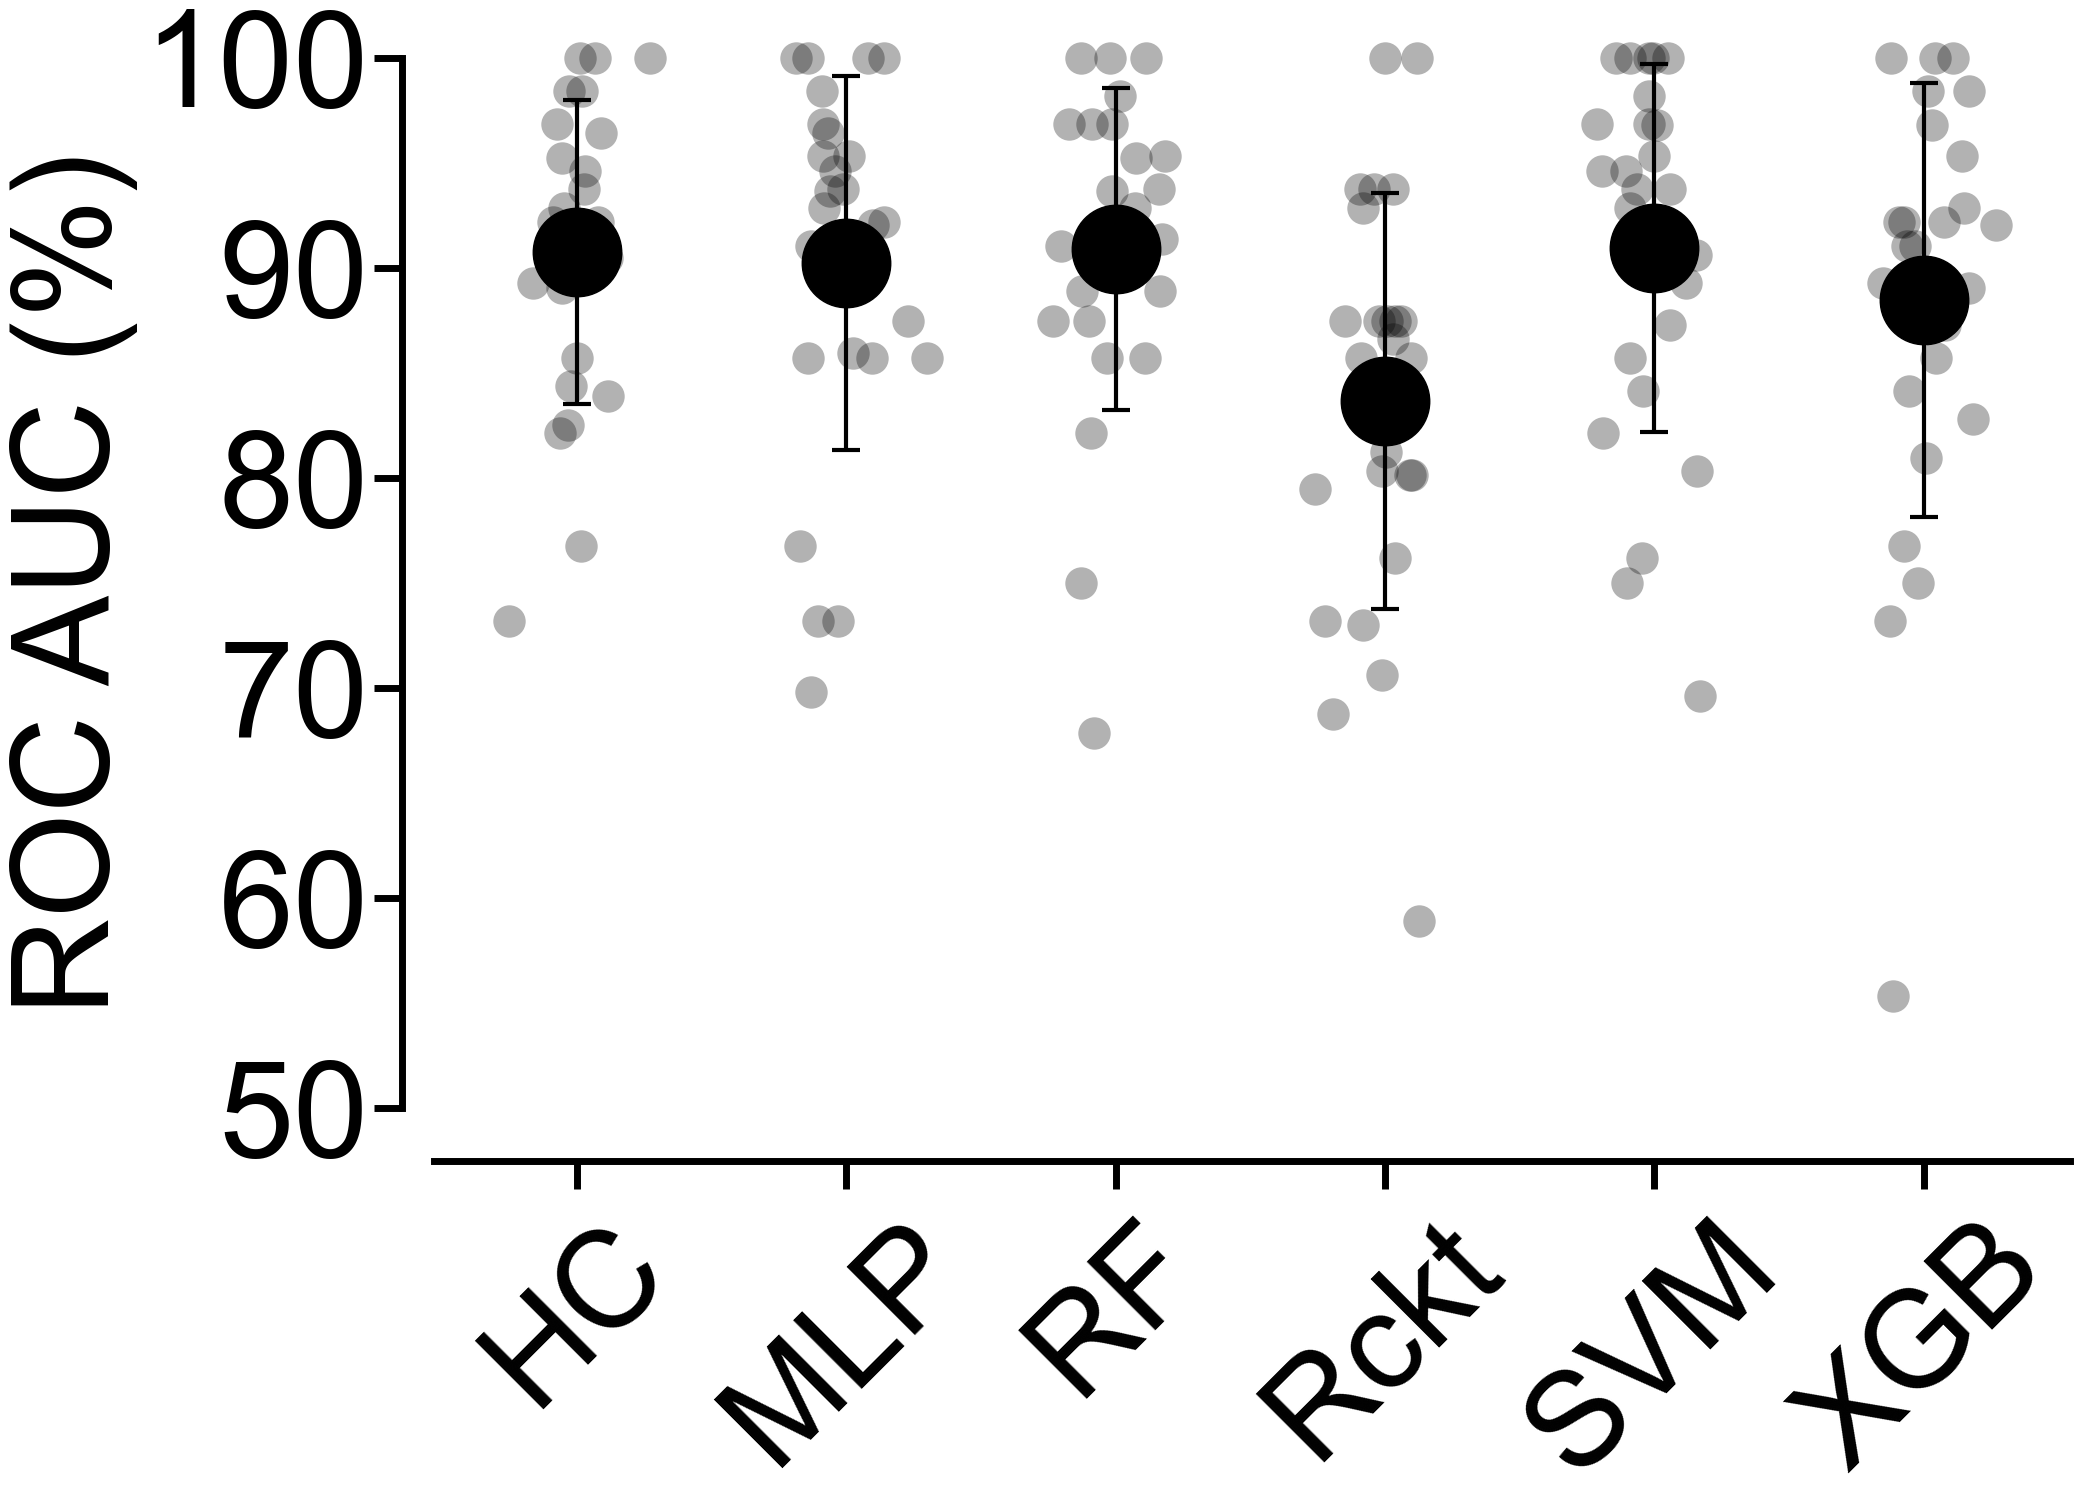

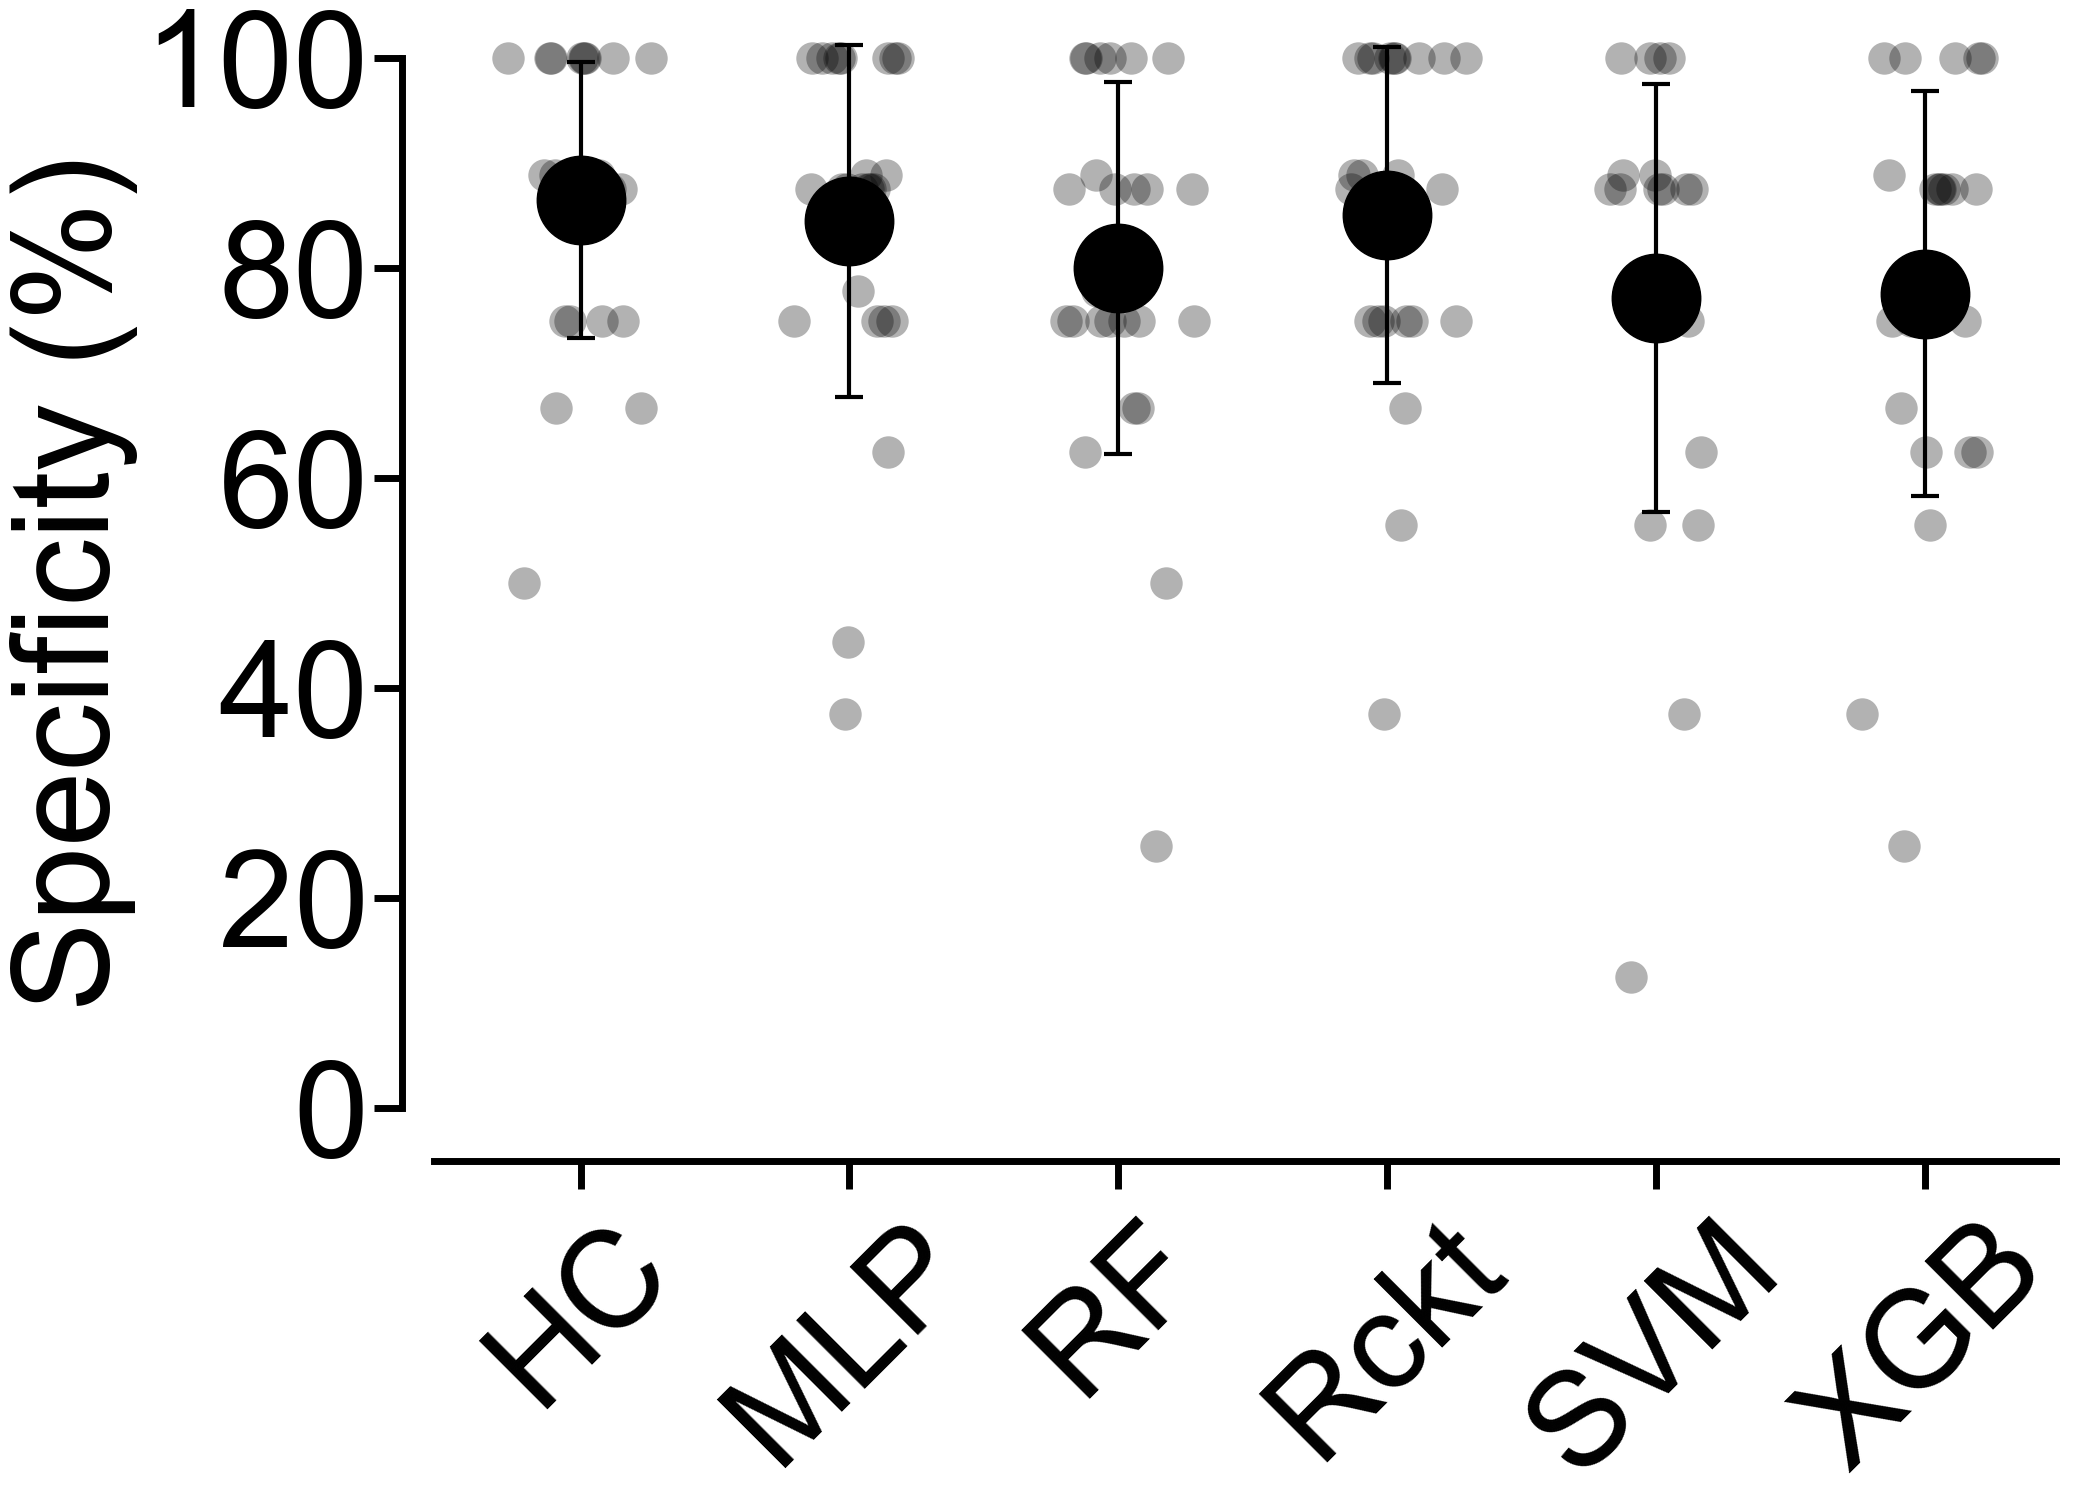

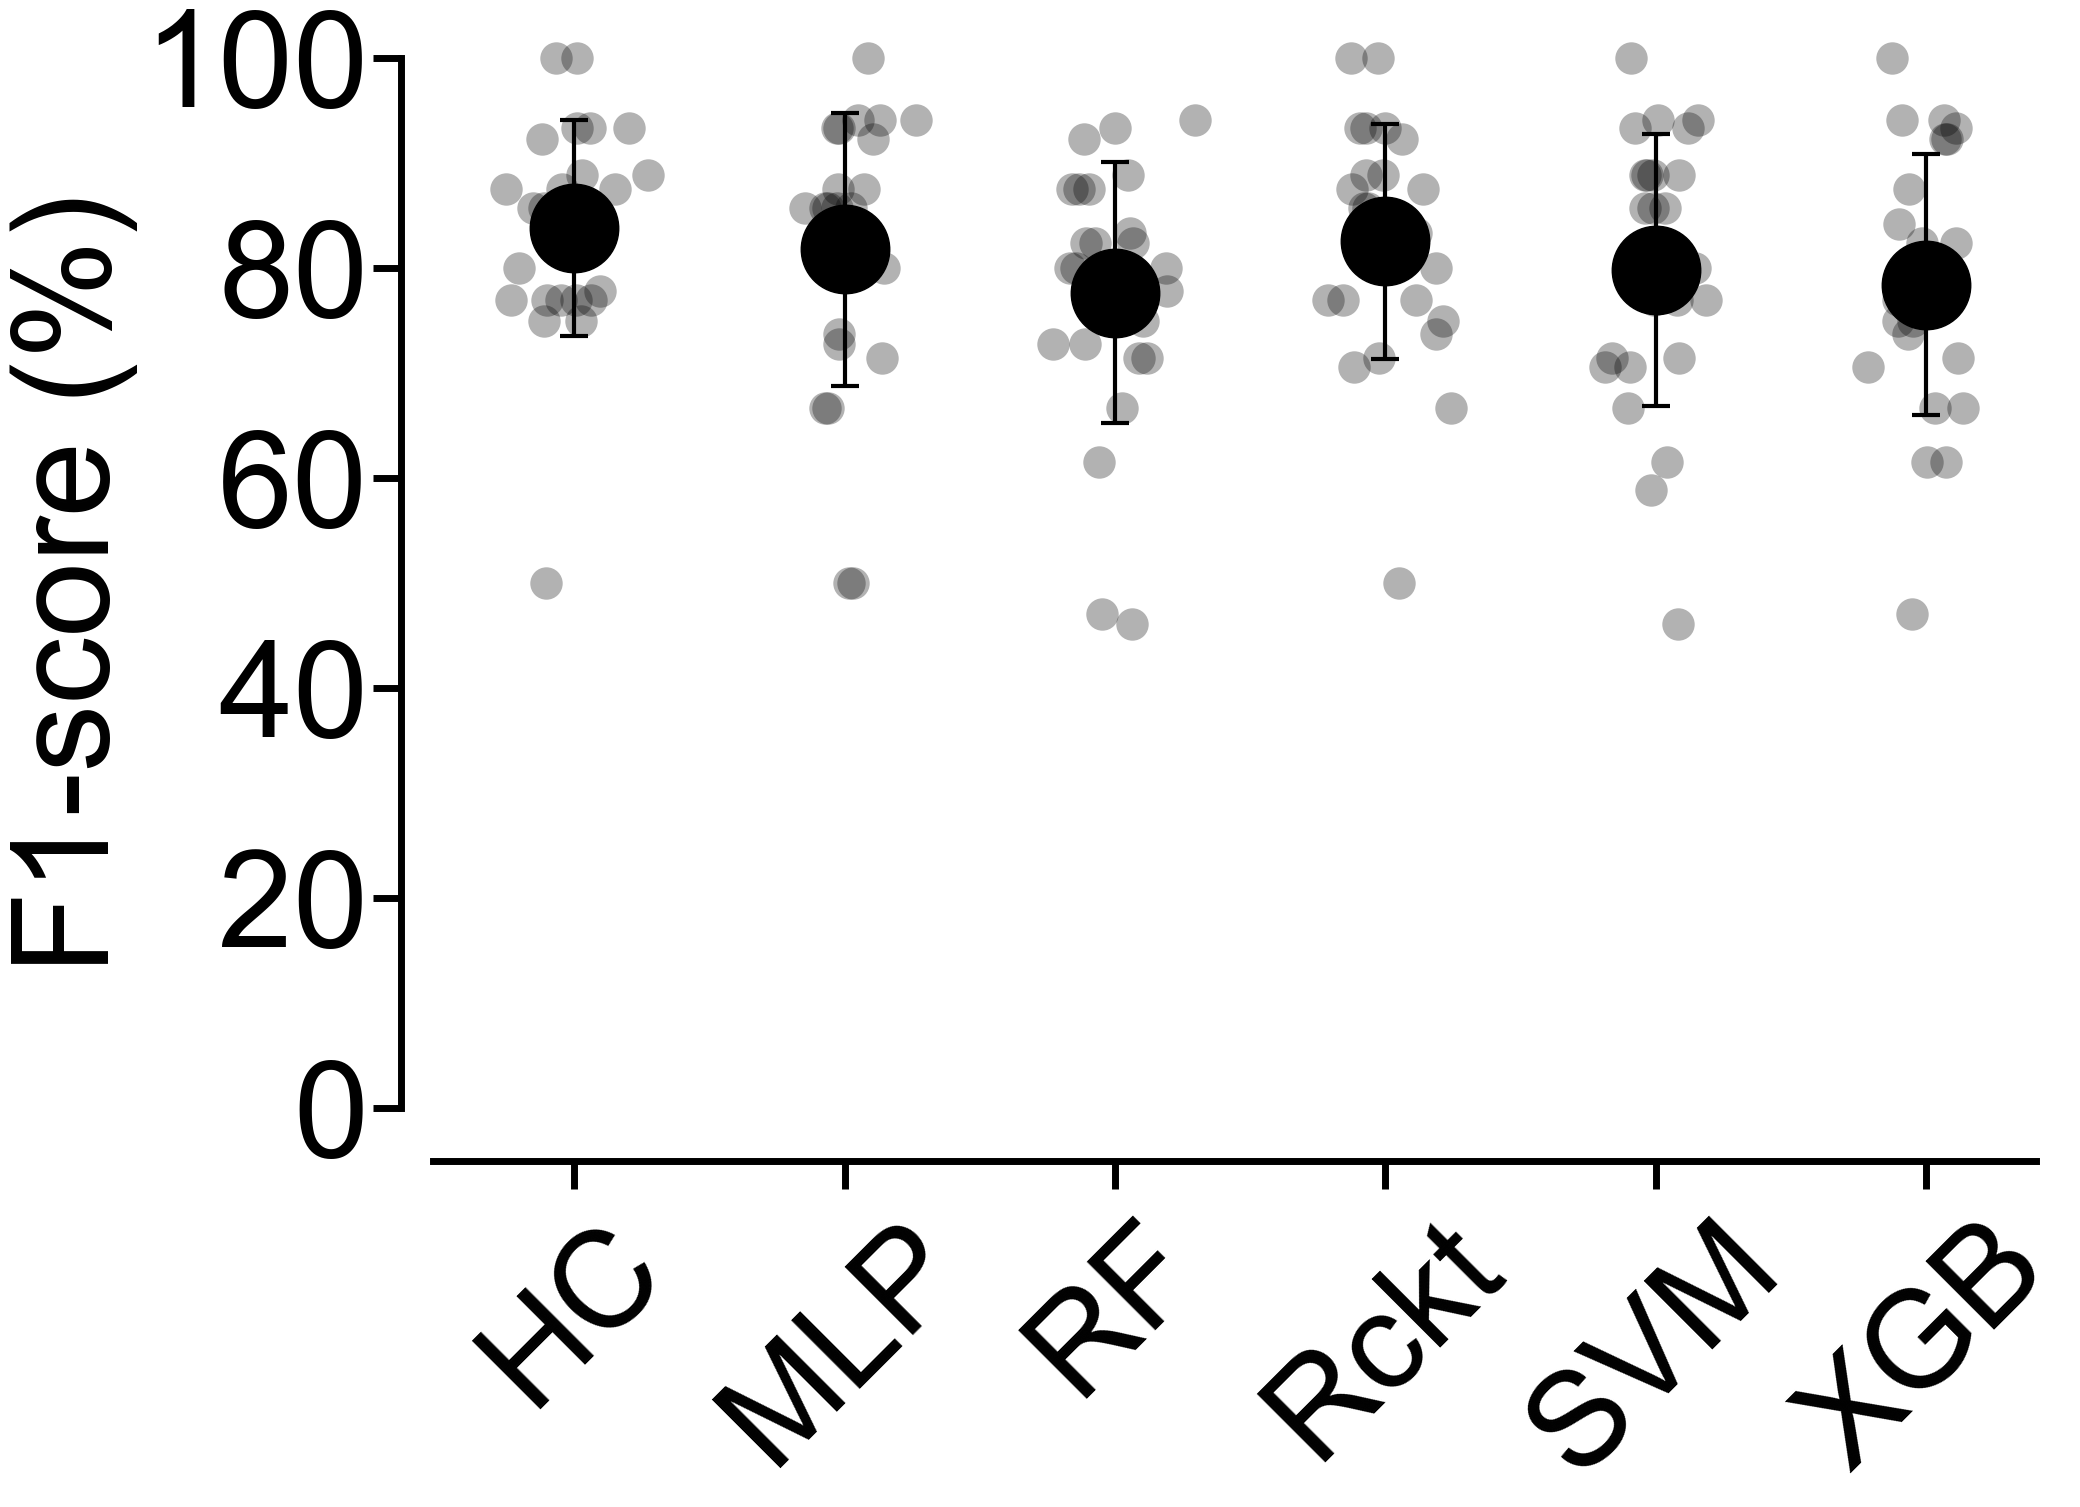

In [10]:
df = master[master['Frequency']=='Click']
ax,le= figureTools.makeMetricFigure(df,ylabel='Accuracy (%)',figureSizeSF=[1.4,1.4],fontSize=fontSize)
ax.set_ylim(50,100)
savefig('./Panels/accuracy_click.pdf',transparent=True,dpi=1200)


df = master[master['Frequency']=='Click']
ax,le = figureTools.makeMetricFigure(df,'test_precision_scorer_6N',le=le,ylabel='Precision (%)',figureSizeSF=[1.4,1.4],fontSize=fontSize)

ax.set_ylim(0,100)
savefig('./Panels/precision_click.pdf',transparent=True,dpi=1200)


df = master[master['Frequency']=='Click']
ax,le = figureTools.makeMetricFigure(df,'test_recall_scorer_6N',le=le,ylabel='Recall (%)',figureSizeSF=[1.4,1.4],fontSize=fontSize)

ax.set_ylim(0,100)
ax.set_ylim(0,100)
savefig('./Panels/recall_click.pdf',transparent=True,dpi=1200)


df = master[master['Frequency']=='Click']
ax,le = figureTools.makeMetricFigure(df,'roc_auc_score',le=le,ylabel = 'ROC AUC (%)',figureSizeSF=[1.4,1.4],fontSize=fontSize)
ax.set_ylim(50,100)
ax.set_ylim(50,100)
savefig('./Panels/rocauc_click.pdf',transparent=True,dpi=1200)


df = master[master['Frequency']=='Click']
ax,le = figureTools.makeMetricFigure(df,'test_recall_scorer_Rep',le=le,ylabel='Specificity (%)',figureSizeSF=[1.4,1.4],fontSize=fontSize)

ax.set_ylim(0,100)
ax.set_ylim(0,100)
savefig('./Panels/specificity_click.pdf',transparent=True,dpi=1200)


df = master[master['Frequency']=='Click']
ax,le = figureTools.makeMetricFigure(df,'test_f1_scorer_6N',le=le,ylabel='F1-score (%)',figureSizeSF=[1.4,1.4],fontSize=fontSize)

ax.set_ylim(0,100)
ax.set_ylim(0,100)
savefig('./Panels/f1_score_click.pdf',transparent=True,dpi=1200)

Confusion matrices

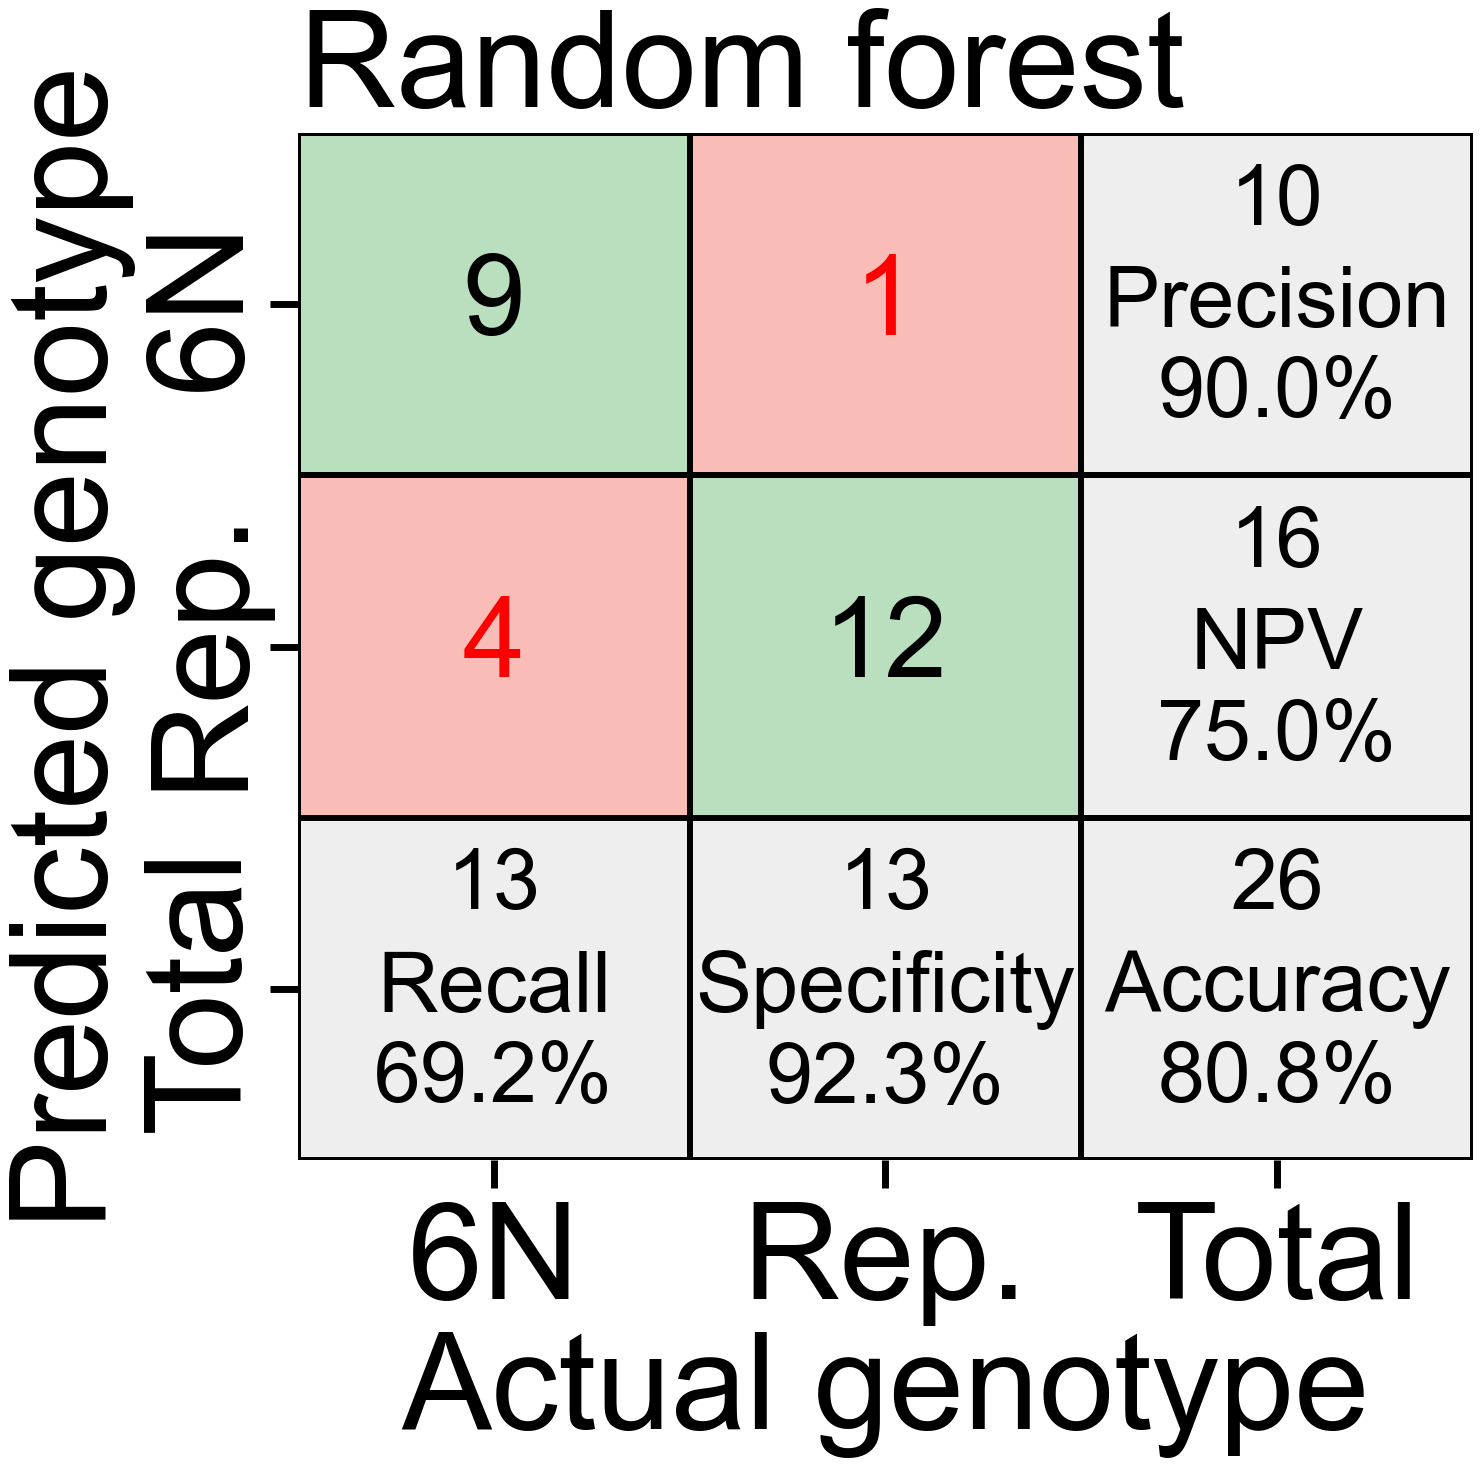

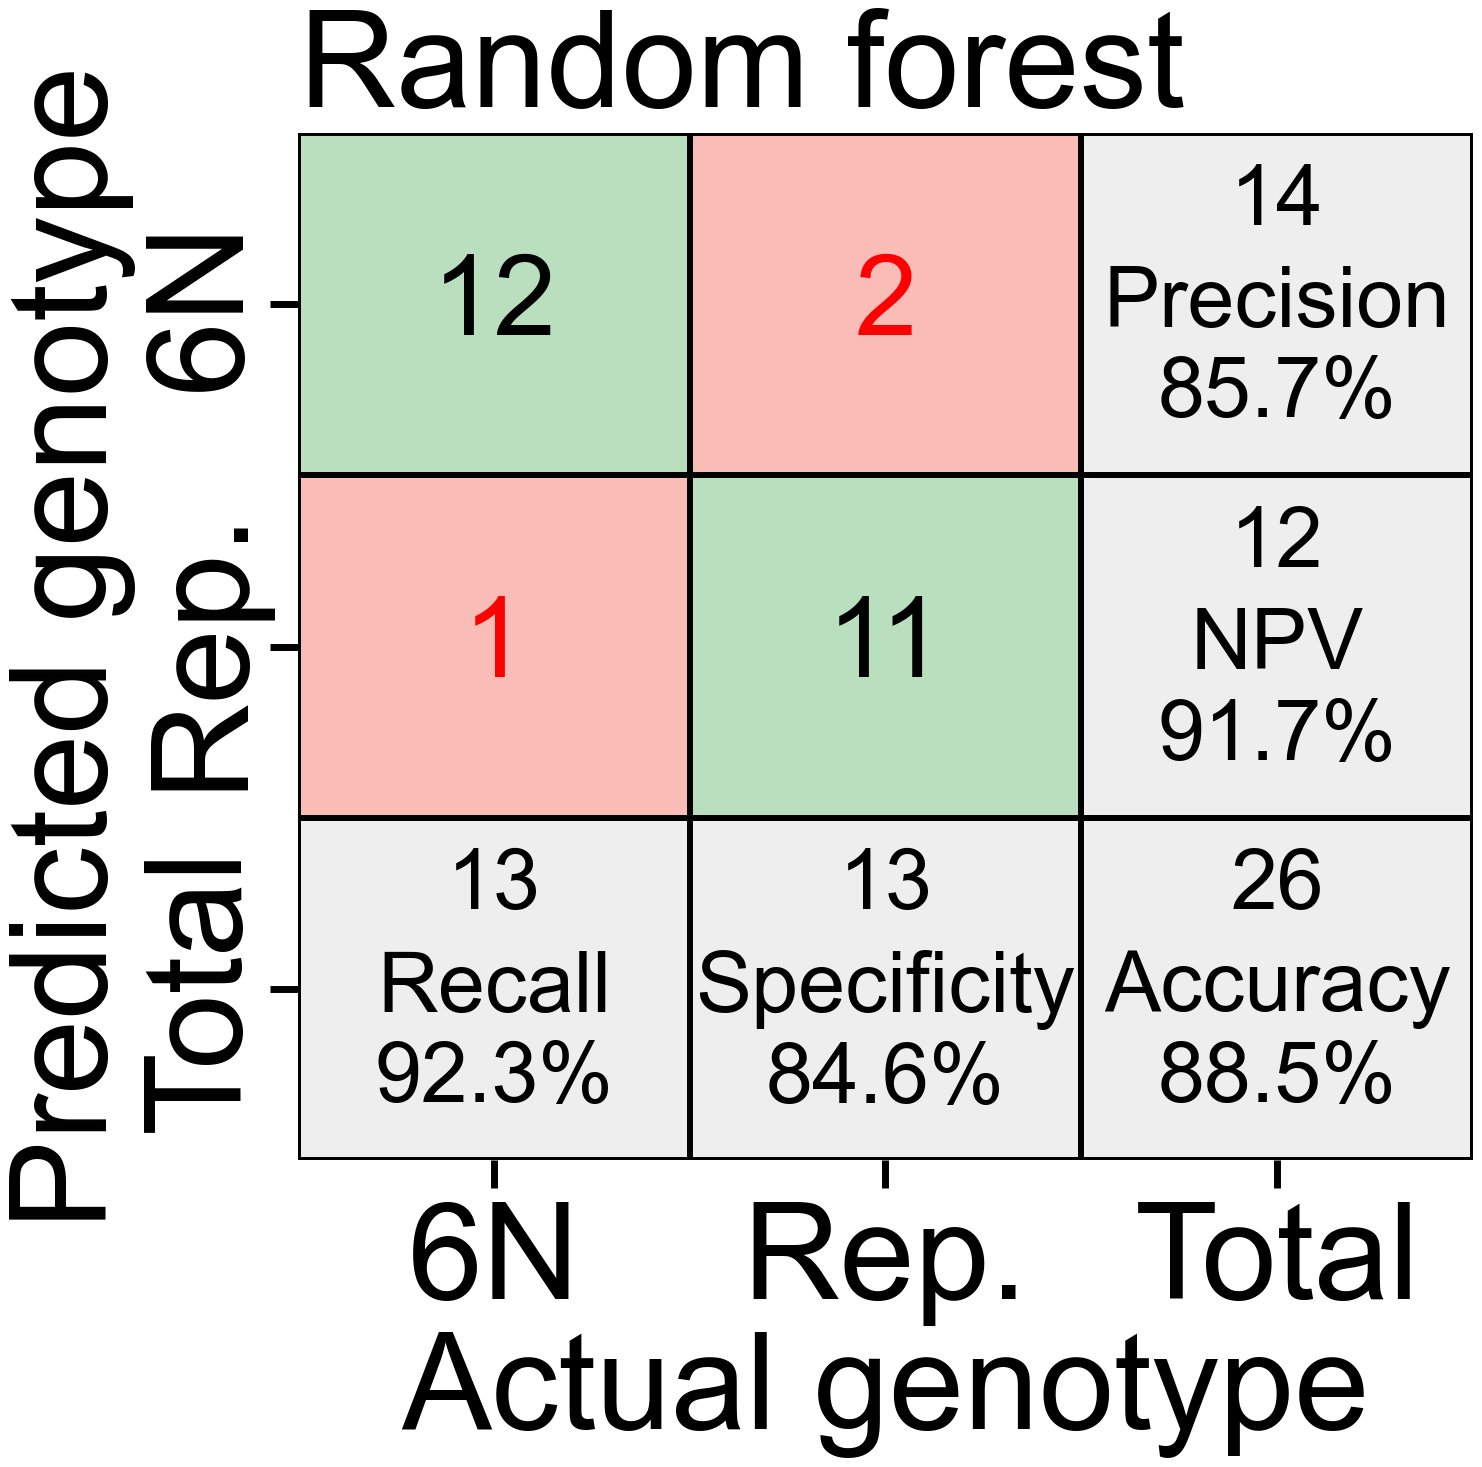

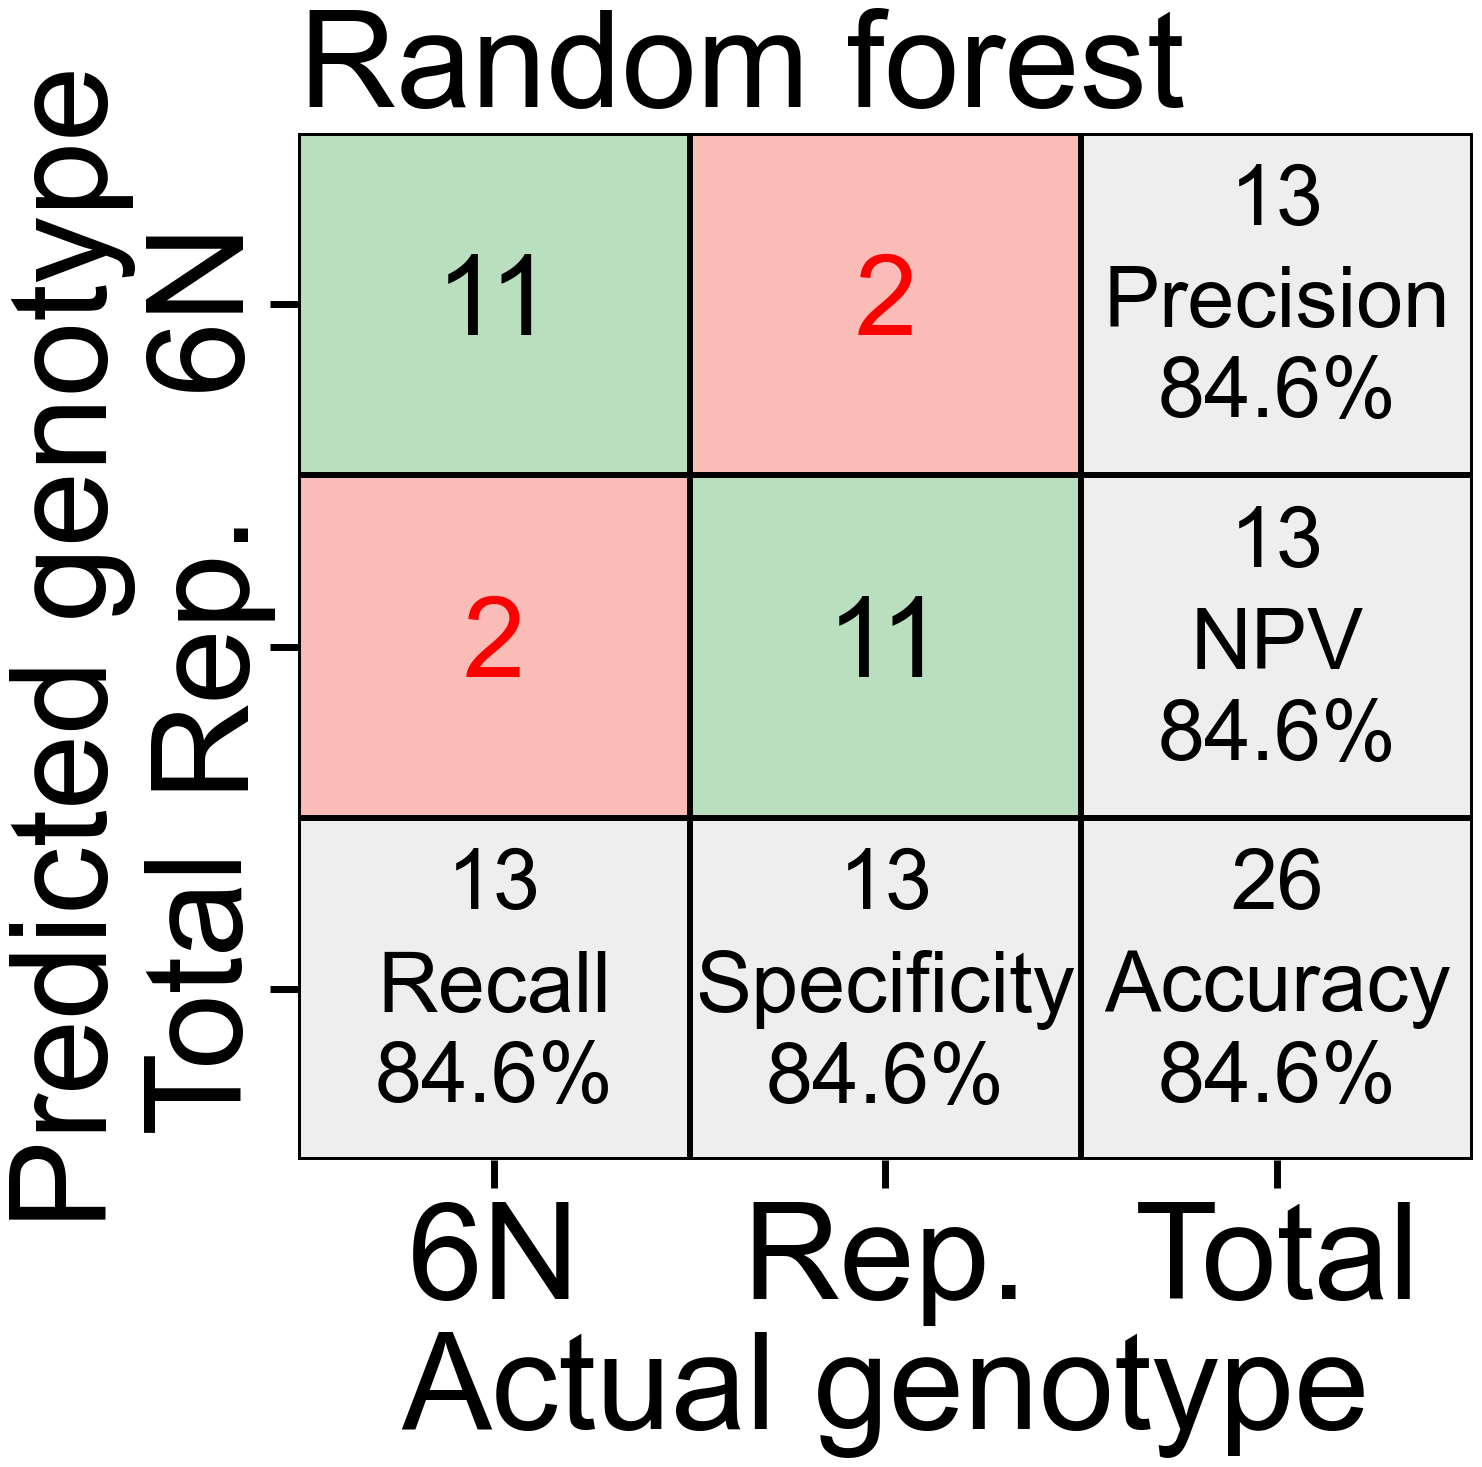

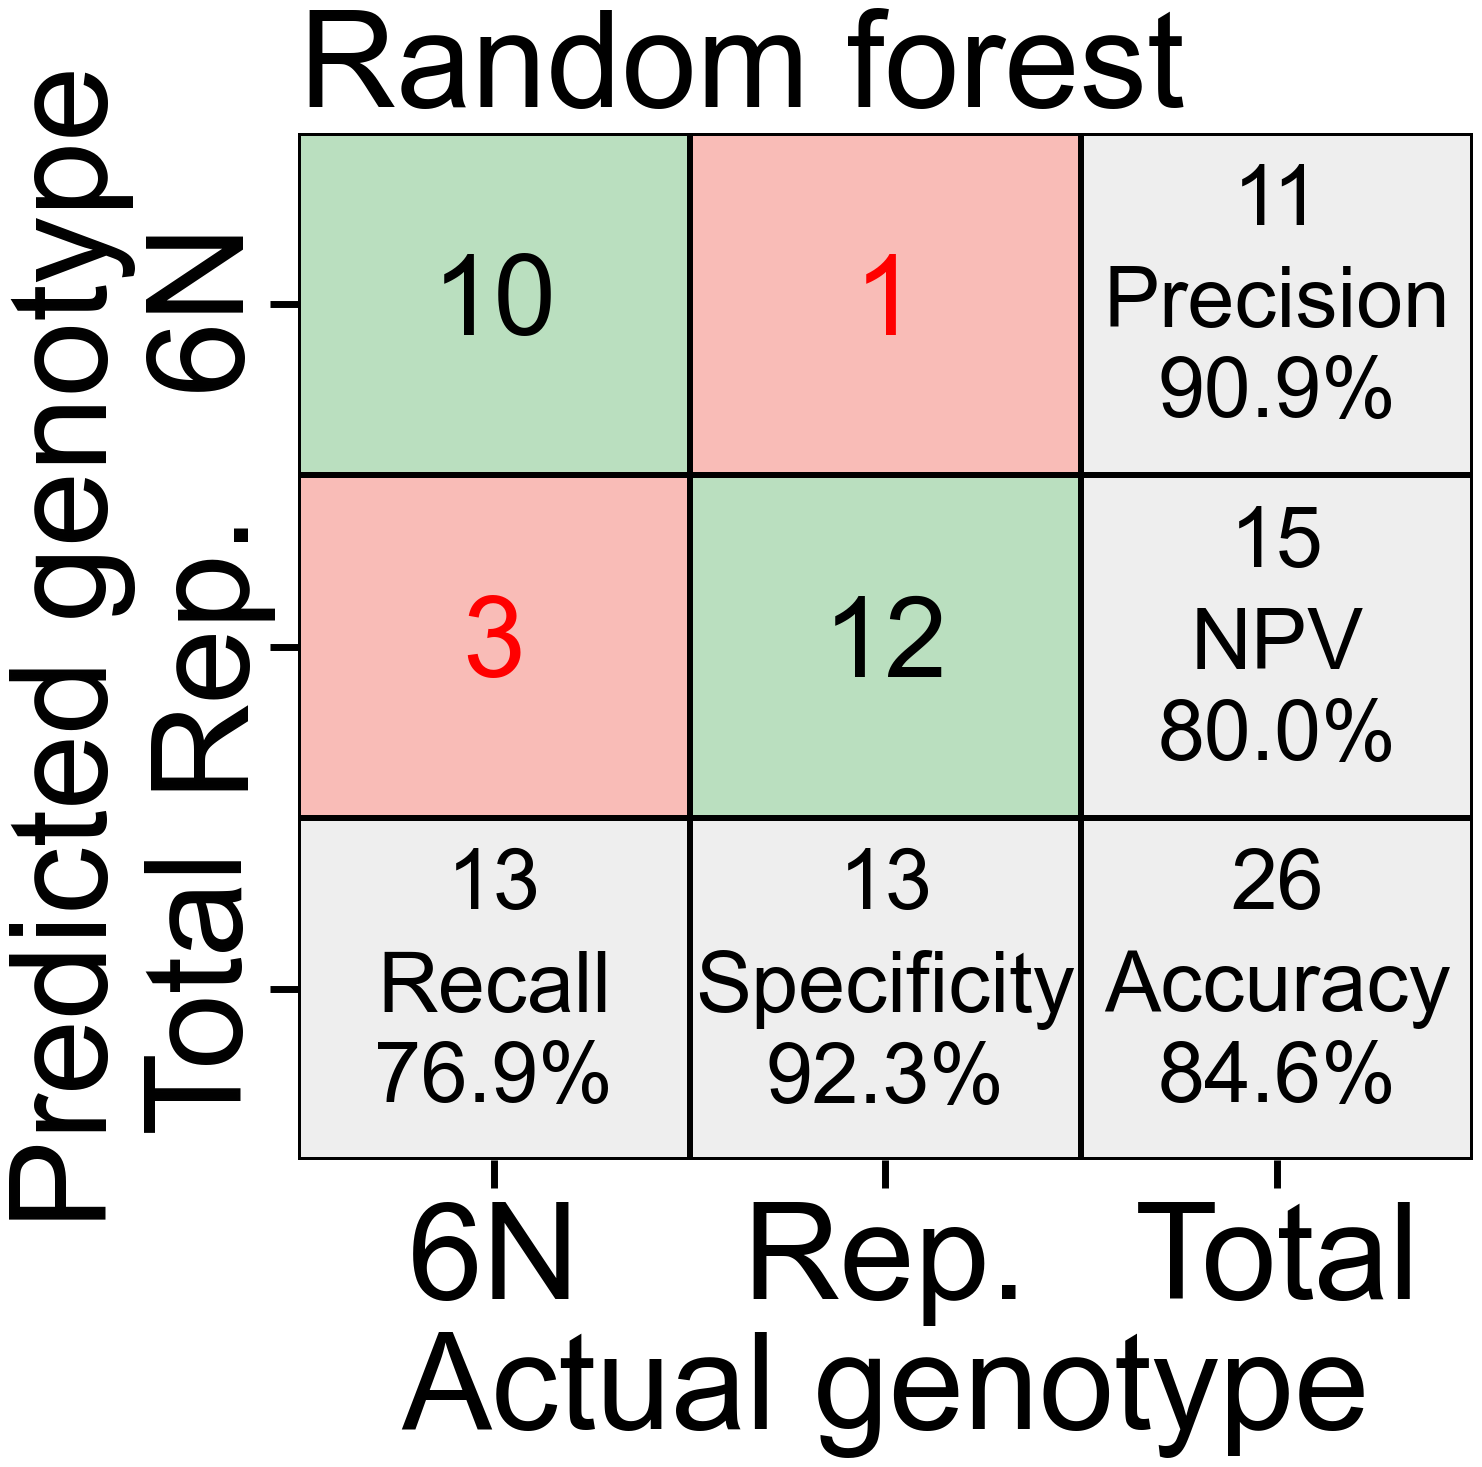

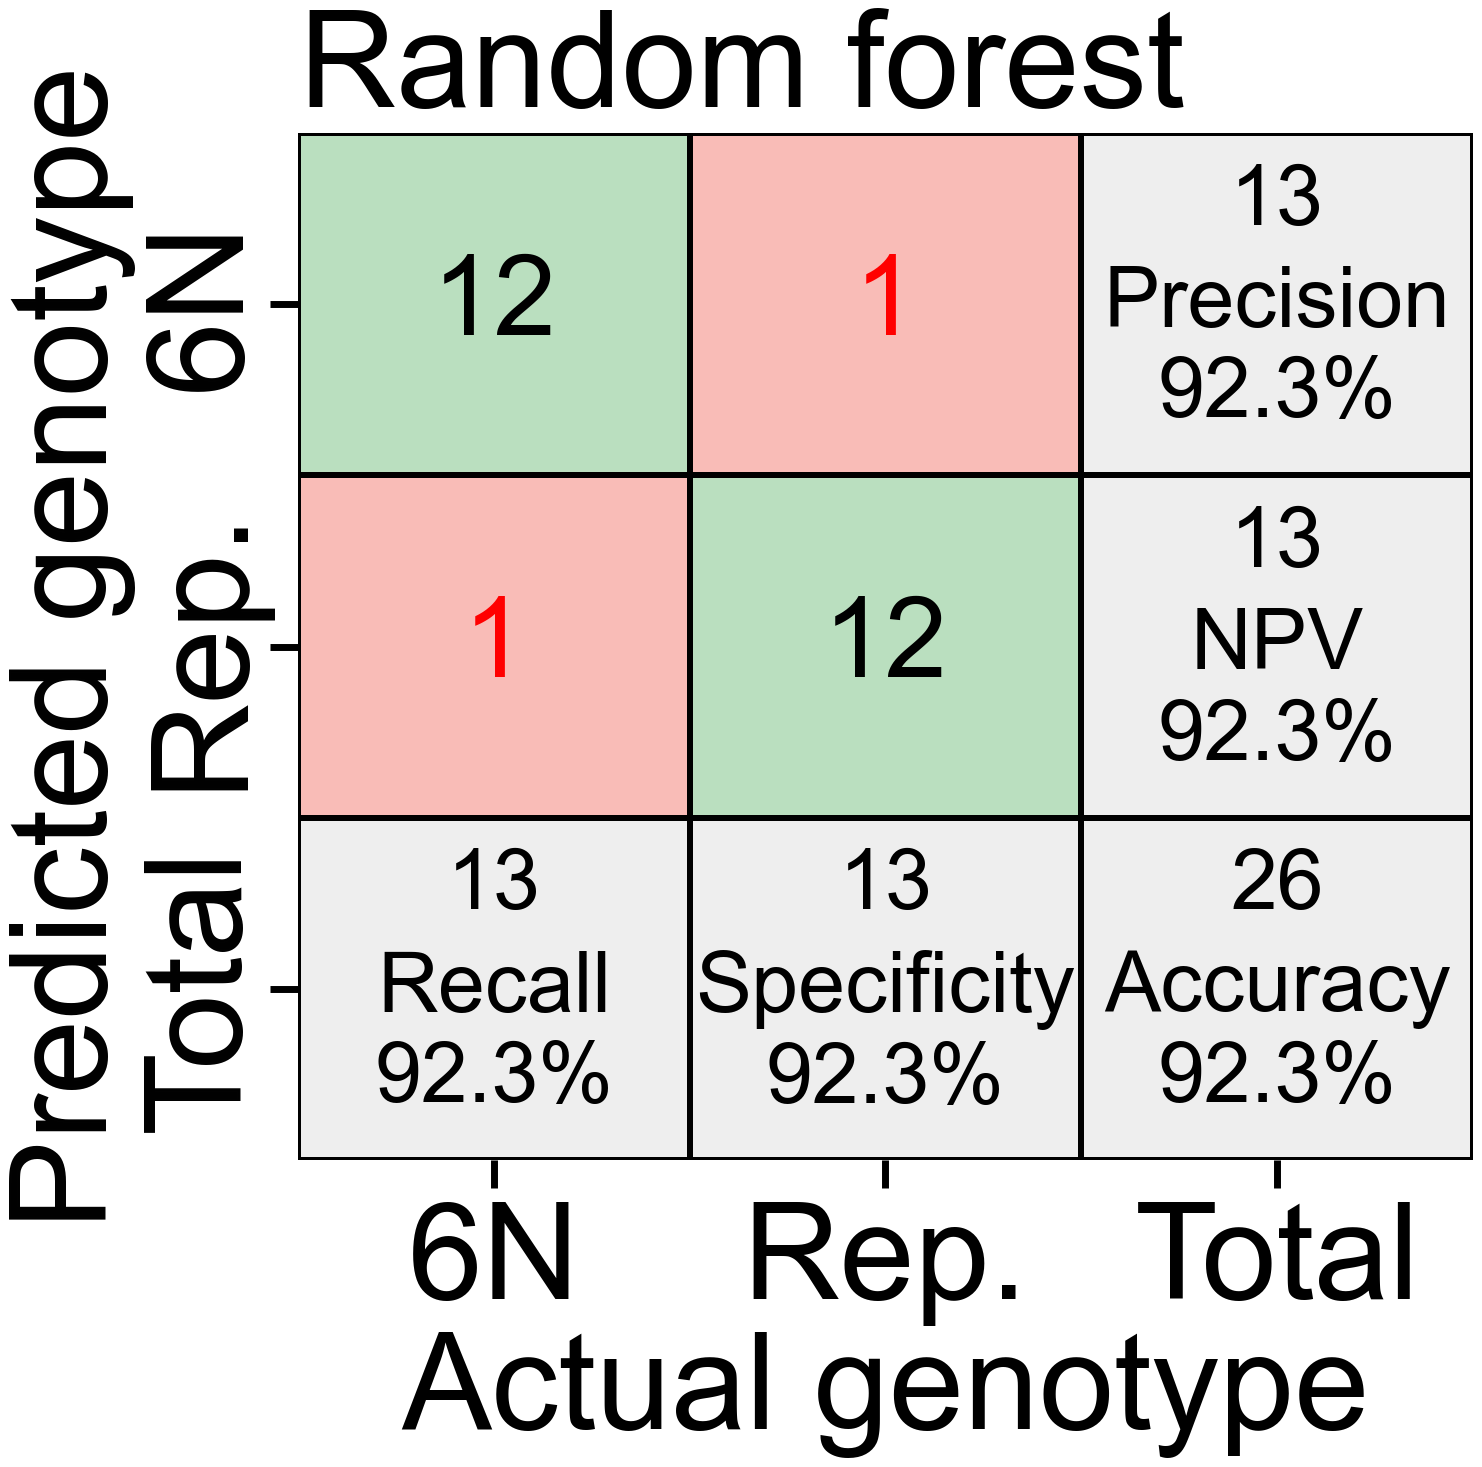

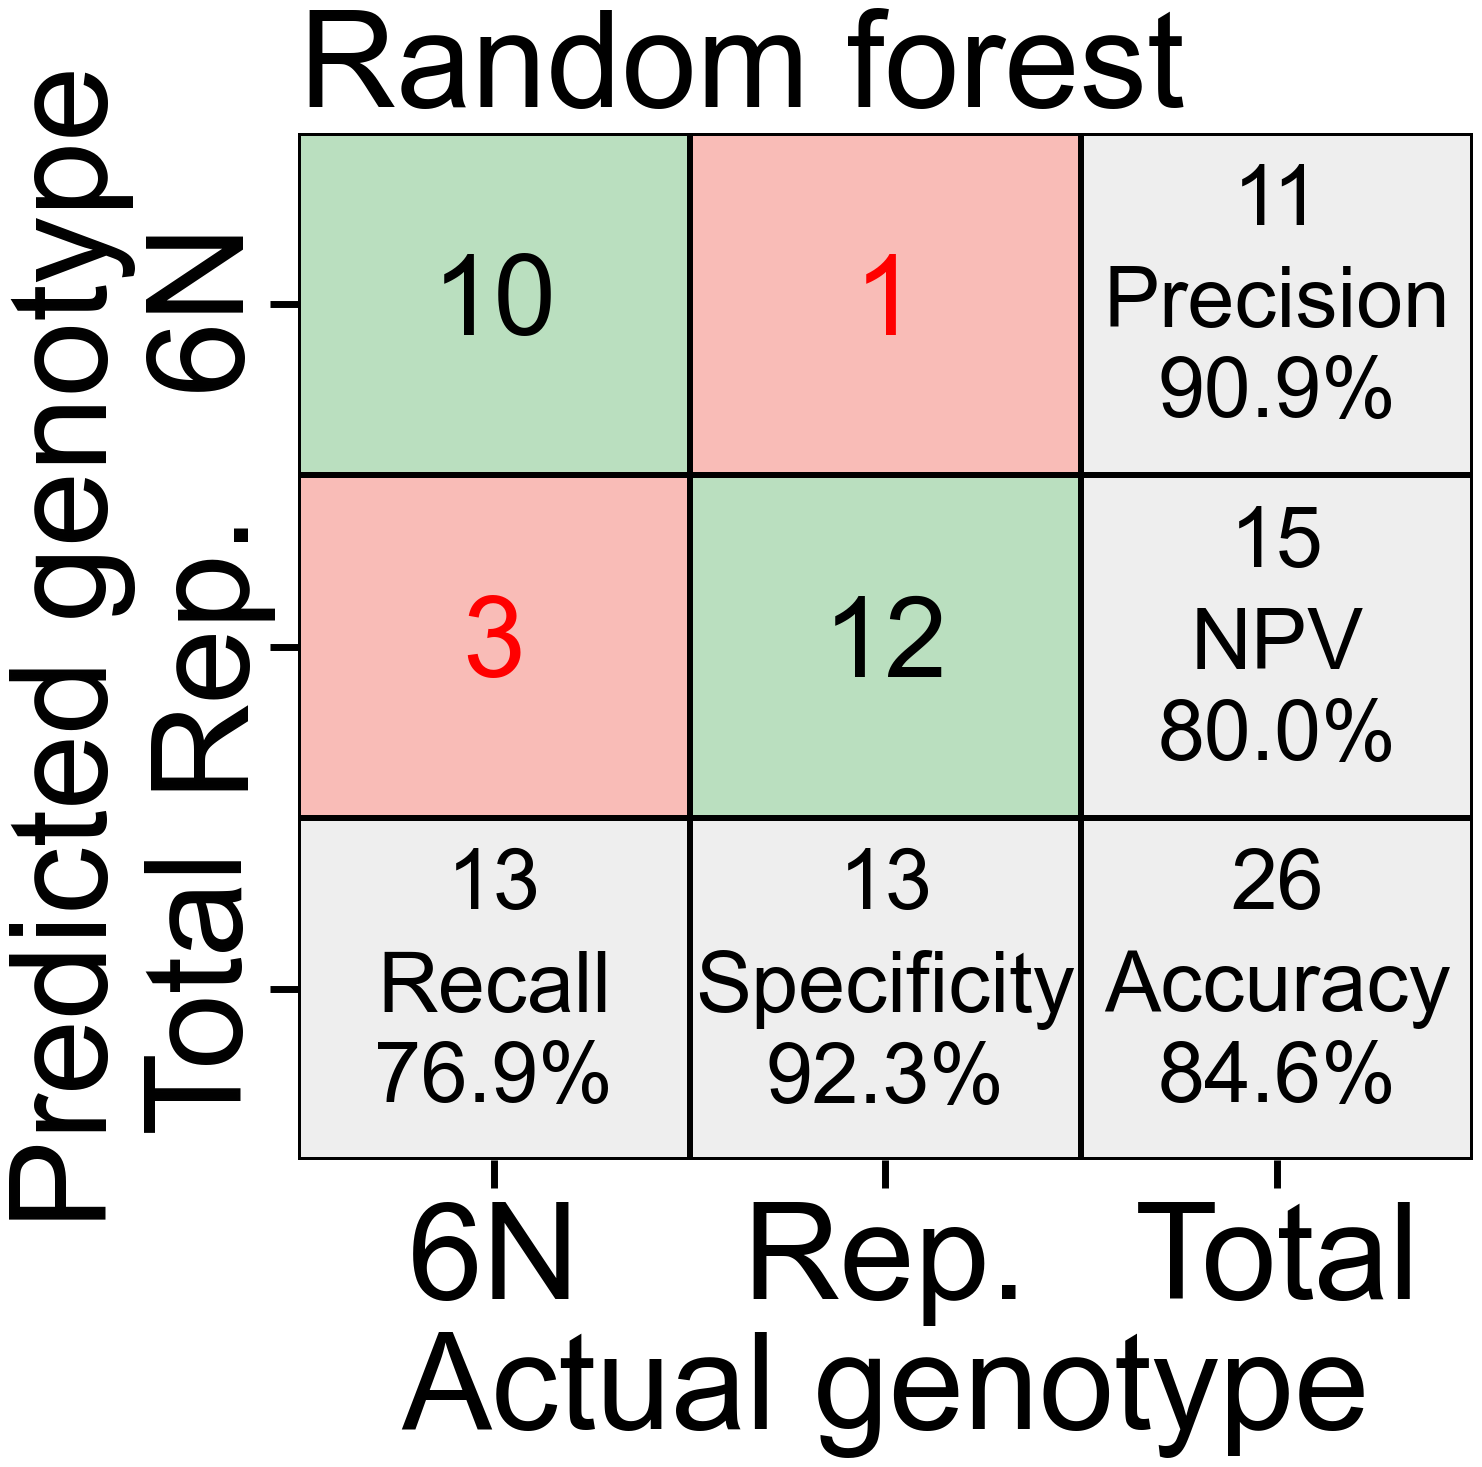

In [10]:
df = pd.read_csv(os.path.join(resultFolder,'forest_kFoldCrossValidation_AnovaFS10percentClicktestResults.csv'),index_col=0)
y_test = df['y_test']
y_predict = df['y_predict']
fig = figureTools.makeConfMatrix(y_test,y_predict,'Random forest',fontSize=fontSize,innerFontSize=54*1.5)
fig.savefig('./Panels/cm_rf_click.pdf',dpi=1200)

df = pd.read_csv(os.path.join(resultFolder,'SVC_kFoldCrossValidation_AnovaFS10percent_ClicktestResults.csv'),index_col=0)
y_test = df['y_test']
y_predict = df['y_predict']
fig = figureTools.makeConfMatrix(y_test,y_predict,'SVM',fontSize=fontSize,innerFontSize=54*1.5)
fig.savefig('./Panels/cm_svc_click.pdf',dpi=1200)

df = pd.read_csv(os.path.join(resultFolder,'XGBOOST_kFoldCrossValidation_AnovaFS10percent_ClicktestResults.csv'),index_col=0)
y_test = df['y_test']
y_predict = df['y_predict']
fig = figureTools.makeConfMatrix(y_test,y_predict,'XGBOOST',fontSize=fontSize,innerFontSize=54*1.5)
fig.savefig('./Panels/cm_xgb_click.pdf',dpi=1200)


df = pd.read_csv(os.path.join(resultFolder,'ROCKET_kFoldCrossValidation_AnovaFS10percent_ClicktestResults.csv'),index_col=0)
y_test = df['y_test']
y_predict = df['y_predict']
fig = figureTools.makeConfMatrix(y_test,y_predict,'ROCKET',fontSize=fontSize,innerFontSize=54*1.5)
fig.savefig('./Panels/cm_rocket_click.pdf',dpi=1200)



df = pd.read_csv(os.path.join(resultFolder,'MLP_kFoldCrossValidation_AnovaFS10percent_ClicktestResults.csv'),index_col=0)
y_test = df['y_test']
y_predict = df['y_predict']
fig = figureTools.makeConfMatrix(y_test,y_predict,'MLP',fontSize=fontSize,innerFontSize=54*1.5)
fig.savefig('./Panels/cm_mlp_click.pdf',dpi=1200)


# #Hc takes 10 minutes to run.
df = pd.read_csv(os.path.join(resultFolder,'hivecote_kFoldCrossValidation_AnovaFS10percent_ClicktestResults.csv'),index_col=0)
y_test = df['y_test']
y_predict = df['y_predict']
fig = figureTools.makeConfMatrix(y_test,y_predict,'HiveCote v2.0',fontSize=fontSize,innerFontSize=54*1.5)
fig.savefig('./Panels/cm_hc_click.pdf',dpi=1200)


# Shapley coefficients plots

In [8]:
import joblib
import figureTools

In [9]:
data,thresholds,dataversion = at.loadFiles(datafolder='../../data')
abr6N = []
abrRep = []
folderN = 1
for i,el in data.iterrows():
    strain = el['Strain']
    if not pd.isna(el[f'Folder {folderN}']):
        folder = os.path.join('../../data',el[f'Folder {folderN}'][2:])
        abr = at.extractABR(folder)
        if strain =='6N':
            abr6N.append(abr)
        elif strain =='Repaired':
            abrRep.append(abr)

abr = pd.concat(abr6N+abrRep).reset_index().groupby(['level_0','level_1']).mean()

The dataset version is: 20230914 - V41


In [10]:

# savgolFilterOrder = 41
# cmap = cm.Reds

# #Random forest 10%Anova Global
# fi = pd.read_csv(os.path.join(resultFolder,'forest_kFoldCrossValidation_AnovaFS10percentClickShapCoeff.csv'),index_col=0)
# fi = abs(fi).mean(1).values
# fi = savgol_filter(fi,savgolFilterOrder,1)
# fig,axs = figureTools.makeFigureFeatureImportance(abr.reset_index().values[:,0],abr.reset_index().values[:,1],abr.values,fi,title=' ',linecolor='k',cmap=cmap,columns=[0],figsize=np.array([ 15.8 ,  16.35]))

# fig.savefig('./Panels/forest_shapley_Click.pdf',dpi=1200,transparent=True)

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def makeFigureFeatureImportanceSingle(h1,h2,out,fi,title,thresholds = None,fig=None,axs=None,linecolor = 'k',cmap=plt.cm.inferno,columns=np.arange(9),figsize=np.array([ 15.8/3 ,  16.35]),fontSize=28,
                                       linewidth=2,alpha=1,tl=True):
    '''
    Make a figure from ABR trace data
    '''
    frequency = [h1[0]]#[100,3000,6000, 12000,18000,24000,30000,36000,42000 ]
    intensity = h2#arange(0,100,5)
    
    nint = len(intensity)
    
    nfreq=1
    freqmap=dict(zip(frequency,np.arange(len(frequency))))
    imap = dict(zip(intensity,np.arange(len(intensity))))

    ntraces = 153
    ppt = 1953 #points per trace
    

    if fig is None:
        fig,axs=plt.subplots(nint,nfreq,sharex=False, sharey=False,subplot_kw={'xticks': [], 'yticks': []},figsize=figsize)
    for i in range(len(intensity)):
        row = i#imap[int(h2[i])]

        #plotn = i+row*len(frequency)
        linecol = linecolor


        axs[nint-row-1].plot(out[i,2:],c=linecol,linewidth=linewidth,alpha=alpha)

        if nint-row-1==0:
            tit1 = int(h1[i])

            if tit1 == 100:
                tit='Click'
            else:
                tit = str(int(tit1/1000))+' kHz'
            axs[nint-row-1].set_title(tit,fontsize=fontSize,ha='center')
        
        
        #axs[nint-row-1].set_ylabel(str(int(h2[i]))+' dB')
    
    
    if fi is not None:
        for row in range(nint):
            tr = fi[(16-row)*ppt:(16-row+1)*ppt]
            currAx = row
            ax = fig.axes[currAx]
            divider = make_axes_locatable(ax)

            ax2 = divider.append_axes("bottom", size="100%", pad=-0.1, sharex=ax)
            #ax2.plot(tr,'r')
        # ax2.set_ylim(fi.min(),fi.max())
            ax2.imshow(tr.reshape((1,-1)),aspect=30,cmap=cmap,vmin=fi.min(),vmax=max(fi),alpha=1,interpolation='None')
        
            
    # ylims=(0,100)
    # for i in range(20,37):
    #     ax = fig.axes[i]
    #     ax.set_ylim(-0.1,0.1)
    #     ax.axis('off')
    if tl:
        plt.tight_layout()   
    for i in range(0,len(intensity)*40):
        try:
            ax = fig.axes[i]
        # ax.set_ylim(-4.5,7)
            ax.axis('off')
            ax.set_xlim(0,10*fs/1000)
        except:
            pass
    fig.patch.set_facecolor('white')
    fig.subplots_adjust(wspace=0.05,hspace=0)


    fig.text(0.08,0.94,'95',fontsize=fontSize, rotation = 0,va='center',ha='center')
    fig.text(0.08,0.97,'dB',fontsize=fontSize, rotation = 0,va='center',ha='center')
    for i in range(16):
        fig.text(0.08,0.0505+i*0.0555,f'{15+5*i}',fontsize=fontSize, rotation = 0,va='center',ha='center')

    fig.suptitle(title,y=1.015,fontsize=fontSize,weight='bold')
    

    return fig,axs


/Users/federico/miniforge3/envs/abr-ml2/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SelectPercentile from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/federico/miniforge3/envs/abr-ml2/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/federico/miniforge3/envs/abr-ml2/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator

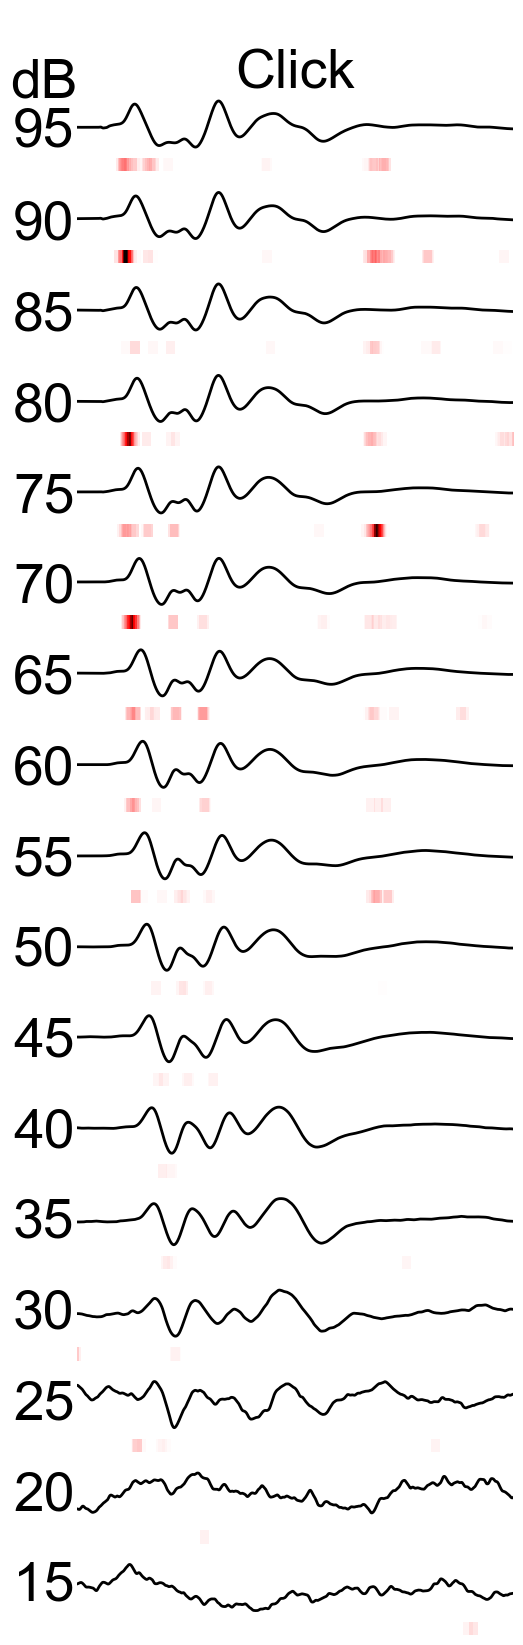

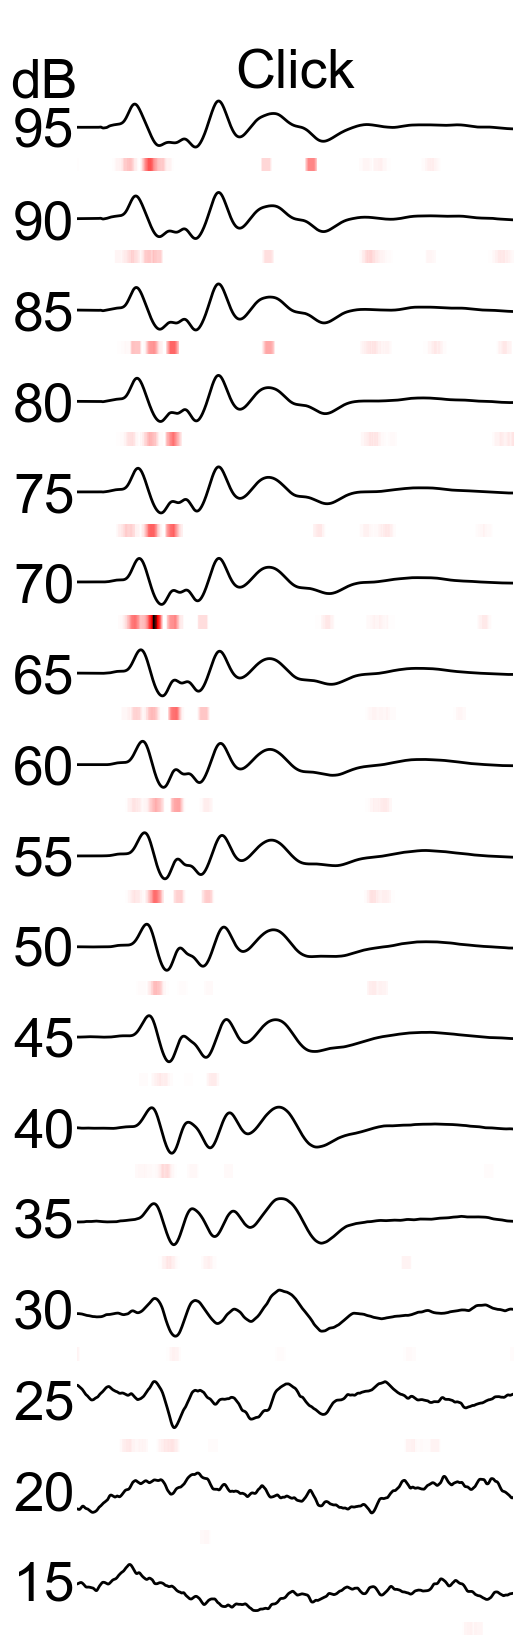

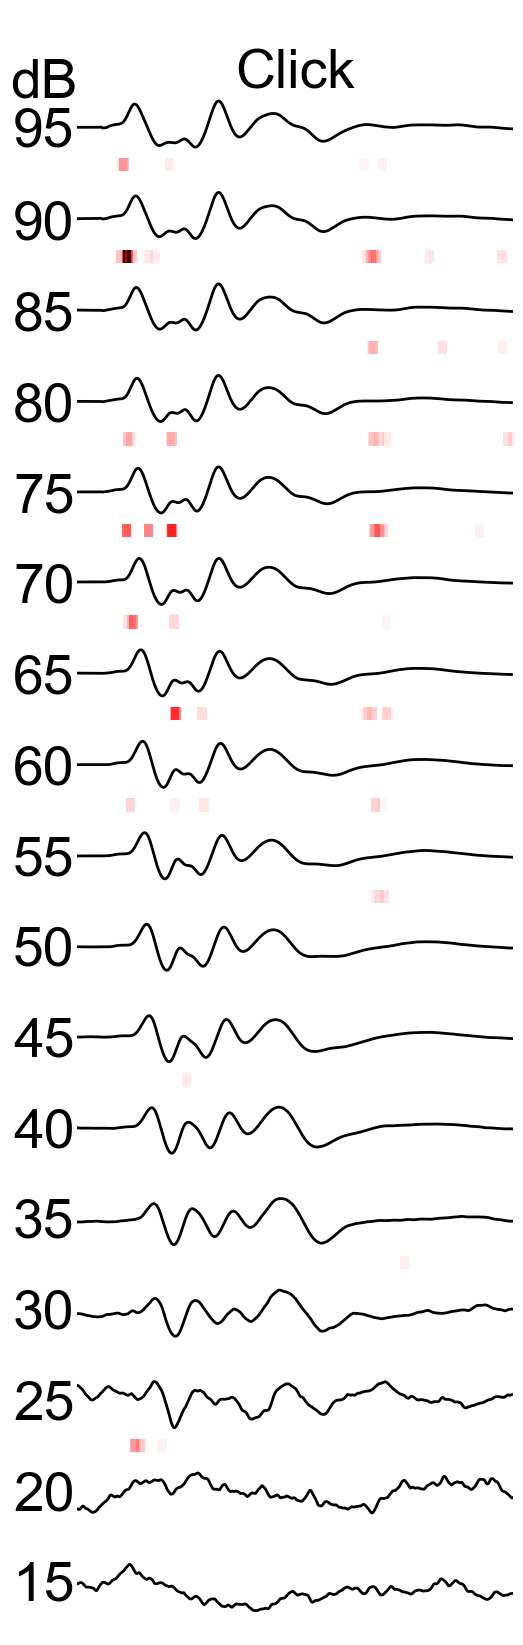

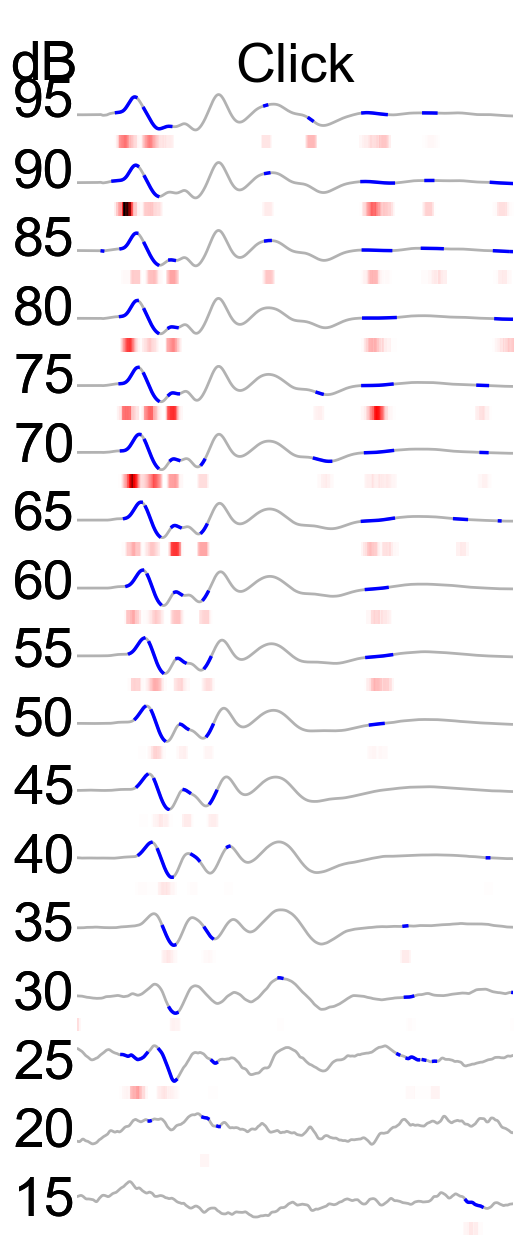

In [21]:
import joblib
from matplotlib.colors import LinearSegmentedColormap

savgolFilterOrder = 21#41



colors = [(1, 1, 1), (1, 0.8, 0.8), (1, 0, 0), (0,0,0)]  # white to light red to red
positions = [0, 0.1, 0.75,1]  # faster transition by moving middle point closer to start
cmap = LinearSegmentedColormap.from_list("custom_reds", list(zip(positions, colors)))

abr100 = abr.reset_index().query('level_0==100 & level_1>=15').sort_values('level_1')
#Random forest 10%Anova Global
fi = pd.read_csv(os.path.join(resultFolder,'forest_kFoldCrossValidation_AnovaFS10percentClickShapCoeff.csv'),index_col=0)
fi = abs(fi).mean(1).values
fi = savgol_filter(fi,savgolFilterOrder,1)
fig,axs = makeFigureFeatureImportanceSingle(abr100.values[:,0],abr100.values[:,1],abr100.values,fi,title=' ',linecolor='k',cmap=cmap,columns=[0],figsize=np.array([ 15.8/3 ,  16.35]),fontSize=fontSize*0.41,linewidth=2,alpha =1)

model_RF = joblib.load(os.path.join(resultFolder,'forest_kFoldCrossValidation_AnovaFS10percentClick.joblib'))
selectPCmodel = model_RF[0]
# Get selected features from the SelectPercentile model
selected_features = selectPCmodel.get_support()

selected_features = selected_features.reshape((17,1953))

dd = abr100.copy()

dd.values[:,2:][~selected_features] = np.nan
#fig,axs = makeFigureFeatureImportanceSingle(abr100.values[:,0],abr100.values[:,1],dd.values,fi,title=' ',linecolor='b',cmap=cmap,columns=[0],
#                                             fontSize=fontSize*0.41,fig=fig,axs=axs,tl=False,linewidth=2.1)


fig.savefig('./Panels/rf_shapley_Click.pdf',dpi=1200,transparent=True)




#SVC 10%Anova Global
fi = pd.read_csv(os.path.join(resultFolder,'SVC_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
fi = abs(fi).mean(1).values
fi = savgol_filter(fi,savgolFilterOrder,1)
fig,axs = makeFigureFeatureImportanceSingle(abr100.values[:,0],abr100.values[:,1],abr100.values,fi,title=' ',linecolor='k',cmap=cmap,columns=[0],figsize=np.array([ 15.8/3 ,  16.35]),fontSize=fontSize*0.41,linewidth=2,alpha = 1)

model_RF = joblib.load(os.path.join(resultFolder,'SVC_kFoldCrossValidation_AnovaFS10percent_Click.joblib'))
selectPCmodel = model_RF[0]
# Get selected features from the SelectPercentile model
selected_features = selectPCmodel.get_support()

selected_features = selected_features.reshape((17,1953))

dd = abr100.copy()

dd.values[:,2:][~selected_features] = np.nan
# fig,axs = makeFigureFeatureImportanceSingle(abr100.values[:,0],abr100.values[:,1],dd.values,fi,title=' ',linecolor='b',cmap=cmap,columns=[0],
#                                              fontSize=fontSize*0.41,fig=fig,axs=axs,tl=False,linewidth=2.5)


fig.savefig('./Panels/SVC_shapley_Click.pdf',dpi=1200,transparent=True)


#XGBOOST 10%Anova Global
fi = pd.read_csv(os.path.join(resultFolder,'xgboost_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
fi = abs(fi).mean(1).values
fi = savgol_filter(fi,savgolFilterOrder,1)
fig,axs = makeFigureFeatureImportanceSingle(abr100.values[:,0],abr100.values[:,1],abr100.values,fi,title=' ',linecolor='k',cmap=cmap,columns=[0],figsize=np.array([ 15.8/3 ,  16.35]),fontSize=fontSize*0.41,linewidth=2,alpha = 1)
model_RF = joblib.load(os.path.join(resultFolder,'xgboost_kFoldCrossValidation_AnovaFS10percent_Click.joblib'))
selectPCmodel = model_RF[0]
# Get selected features from the SelectPercentile model
selected_features = selectPCmodel.get_support()

selected_features = selected_features.reshape((17,1953))

dd = abr100.copy()

dd.values[:,2:][~selected_features] = np.nan
# fig,axs = makeFigureFeatureImportanceSingle(abr100.values[:,0],abr100.values[:,1],dd.values,fi,title=' ',linecolor='b',cmap=cmap,columns=[0],
#                                              fontSize=fontSize*0.41,fig=fig,axs=axs,tl=False,linewidth=2.5)



fig.savefig('./Panels/xgb_shapley_Click.pdf',dpi=1200,transparent=True)

#Average 3 models
#Random forest 10%Anova Global
fi1 = pd.read_csv(os.path.join(resultFolder,'forest_kFoldCrossValidation_AnovaFS10percentClickShapCoeff.csv'),index_col=0)
fi1 = abs(fi1).mean(1).values
fi1 = savgol_filter(fi1,savgolFilterOrder,1)
fi2 = pd.read_csv(os.path.join(resultFolder,'SVC_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
fi2 = abs(fi2).mean(1).values
fi2 = savgol_filter(fi2,savgolFilterOrder,1)
fi3 = pd.read_csv(os.path.join(resultFolder,'xgboost_kFoldCrossValidation_AnovaFS10percent_ClickShapCoeff.csv'),index_col=0)
fi3 = abs(fi3).mean(1).values
fi3 = savgol_filter(fi3,savgolFilterOrder,1)

fi = (fi1/fi1.max()+fi2/fi2.max()+fi3/fi3.max())/3
fig,axs = makeFigureFeatureImportanceSingle(abr100.values[:,0],abr100.values[:,1],abr100.values,fi,title=' ',linecolor='k',cmap=cmap,columns=[0],figsize=np.array([ 15.8/3 ,  12.35]),fontSize=fontSize*0.41,linewidth=2,alpha = 0.3)

model_RF = joblib.load(os.path.join(resultFolder,'xgboost_kFoldCrossValidation_AnovaFS10percent_Click.joblib'))
selectPCmodel = model_RF[0]
# Get selected features from the SelectPercentile model
selected_features = selectPCmodel.get_support()

selected_features = selected_features.reshape((17,1953))

dd = abr100.copy()

dd.values[:,2:][~selected_features] = np.nan
fig,axs = makeFigureFeatureImportanceSingle(abr100.values[:,0],abr100.values[:,1],dd.values,fi,title=' ',linecolor='b',cmap=cmap,columns=[0],
                                             fontSize=fontSize*0.41,fig=fig,axs=axs,tl=False,linewidth=2.5)




fig.savefig('./Panels/forest_shapley_Click.pdf',dpi=1200,transparent=True)


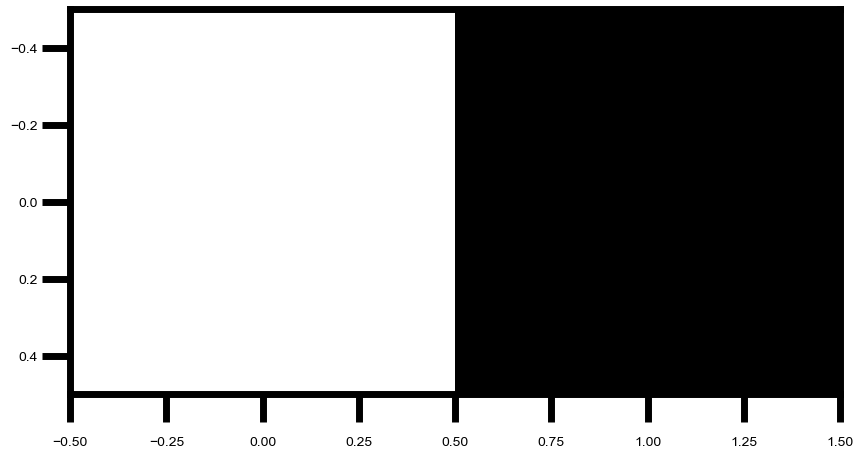

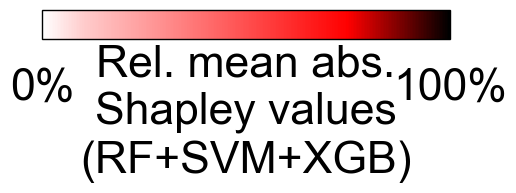

In [19]:

a = np.array([[0,1]])


img = imshow(a, cmap=cmap)
f=figure(figsize=(15.8/3 ,3.7*2.5*1.2))
gs= gridspec.GridSpec(2,1,height_ratios=[30,1],hspace=0,figure=f)
#ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])



colorbar(orientation="horizontal", cax=ax2,mappable=img)
ax2.set_xticks([0,1],['0%','100%'])
ax2.set_xlabel('Rel. mean abs.\nShapley values\n(RF+SVM+XGB)',rotation=0, va='center')
# for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
#             ax1.get_xticklabels() + ax1.get_yticklabels()):
#     item.set_fontsize(28)
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
            ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(fontSize*0.33)
ax2.xaxis.set_tick_params(width=0,length=10,color='w')
[i.set_linewidth(1) for i in ax2.spines.values()]

#ax2.set_frame_on(False)
gs.tight_layout(f)
f.savefig('./Panels/shapleyColorbar_click.pdf',dpi=1200,transparent=True)

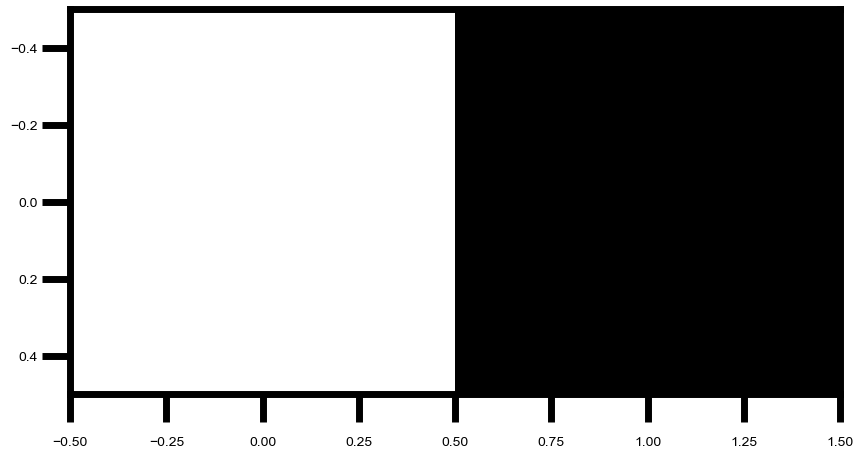

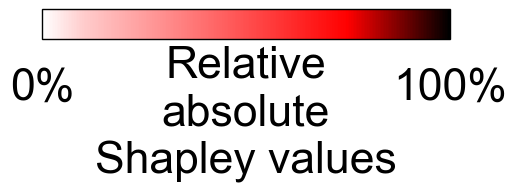

In [25]:

a = np.array([[0,1]])


img = imshow(a, cmap=cmap)
f=figure(figsize=(15.8/3 ,3.7*2.5*1.2))
gs= gridspec.GridSpec(2,1,height_ratios=[30,1],hspace=0,figure=f)
#ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])



colorbar(orientation="horizontal", cax=ax2,mappable=img)
ax2.set_xticks([0,1],['0%','100%'])
ax2.set_xlabel('Relative\nabsolute\nShapley values',rotation=0, va='center')
# for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
#             ax1.get_xticklabels() + ax1.get_yticklabels()):
#     item.set_fontsize(28)
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
            ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(fontSize*0.33)
ax2.xaxis.set_tick_params(width=0,length=10,color='w')
[i.set_linewidth(1) for i in ax2.spines.values()]

#ax2.set_frame_on(False)
gs.tight_layout(f)
f.savefig('./Panels/shapleyColorbar_click_supp.pdf',dpi=1200,transparent=True)